In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# função para exportar em pgf para LaTeX

import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


In [15]:
# função para criar figuras com base no tamanho da página do doc LATEX

def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2 + 0.2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in*1.2 #* golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# SADIS Database

## Data import

In [2]:
# importação dos dados a partir da base tratada #

sadis_semanal = pd.read_csv('SADIS_painel_2009-2019.csv')

In [3]:
# dimensões da base de dados linhas vs. colunas #

sadis_semanal.shape

(68154, 15)

In [5]:
# exibição das 5 primeiras colunas

sadis_semanal.head()

,CPB/ROE,TITULO_DA_OBRA,ANO_CINE,SEMANA_CINE,ANO_LANCAMENTO,SEMANA_LANCAMENTO,LANC_NO_ANO,SEM_DSDE_LANC,DATA_LANC,PAIS_ORIGEM,NACIONALIDADE,PUBLICO,RENDA,SALAS_NO_LANCAMENTO,GENERO
0,B1301902100000,"A Primeira Missa ou Tristes Tropeços, Enganos ...",2014,22,2014,22,True,0.0,2014-05-29 00:00:00,Brasil,Brasileira,245,1517.68,3.0,Ficção
1,B1301902100000,"A Primeira Missa ou Tristes Tropeços, Enganos ...",2014,23,2014,22,True,1.0,2014-05-29 00:00:00,Brasil,Brasileira,274,2193.98,0.0,Ficção
2,B1301902100000,"A Primeira Missa ou Tristes Tropeços, Enganos ...",2014,24,2014,22,True,2.0,2014-05-29 00:00:00,Brasil,Brasileira,67,912.21,0.0,Ficção
3,B1301902100000,"A Primeira Missa ou Tristes Tropeços, Enganos ...",2014,25,2014,22,True,3.0,2014-05-29 00:00:00,Brasil,Brasileira,50,639.98,0.0,Ficção
4,B1301902100000,"A Primeira Missa ou Tristes Tropeços, Enganos ...",2014,43,2014,22,True,21.0,2014-05-29 00:00:00,Brasil,Brasileira,12,86.00,0.0,Ficção


A tabela acima apresenta as 5 primeiras linhas do painel compilado, mostrando as colunas disponíveis e respectivos valores.

Os dados de lançamento foram calculados tendo por base, quando disponíveis, os dados de lançamento de obras disponíveis no Observatório do Cinema e do Audiovisual ([Listagem de filmes brasileiros exibidos de 2009 a 2019](https://oca.ancine.gov.br/sites/default/files/repositorio/csv/2122.csv))

As semanas são sempre calculadas com base na [semana do isocalendário](https://en.wikipedia.org/wiki/ISO_week_date) correspondente.

A coluna SEM_DSDE_LANC calcula apenas a diferença entre semana do lançamento e semana de exibição (SEMANA_CINE).

A informação de salas no lançamento não está disponível para todas as observações dado que algumas são relançamentos de obras para as quais não há dados à época do lançamento.

## Sazonalidade

In [4]:
# agrupando para poder plotar ano a ano, removendo a 53ª semana de alguns anos (no caso só de 2015) #

sadis_sazonal = sadis_semanal.query("SEMANA_CINE <= 52").groupby(
    ['ANO_CINE','SEMANA_CINE','NACIONALIDADE'], as_index=False).agg({
    'RENDA':'sum','PUBLICO':'sum','CPB/ROE':'nunique'
})

# regressão para obter sazonalidade

sadis_saz_total = sadis_sazonal.groupby(['ANO_CINE','SEMANA_CINE',], as_index=False).agg({
    'RENDA':'sum','PUBLICO':'sum','CPB/ROE':'nunique'
})

reg_s1 = smf.ols(formula = 'PUBLICO ~ C(SEMANA_CINE) + C(ANO_CINE)', \
              data=sadis_saz_total).fit()

reg_s2 = smf.ols(formula = 'PUBLICO ~ C(SEMANA_CINE) + C(ANO_CINE)', \
              data=sadis_sazonal.query("NACIONALIDADE == 'Estrangeira'")).fit()

reg_s3 = smf.ols(formula = 'PUBLICO ~ C(SEMANA_CINE) + C(ANO_CINE)', \
              data=sadis_sazonal.query("NACIONALIDADE == 'Brasileira'")).fit()

# arrumando os dados para poder plotar o gráfico, pegando os intervalos de confiança #

s1_res = pd.read_html(reg_s1.summary().tables[1].as_html(),header=0,index_col=0)[0]
s2_res = pd.read_html(reg_s2.summary().tables[1].as_html(),header=0,index_col=0)[0]
s3_res = pd.read_html(reg_s3.summary().tables[1].as_html(),header=0,index_col=0)[0]

s1_res['CI_low'], s1_res['CI_high'] = reg_s1.conf_int(alpha=0.05).iloc[:,0], reg_s1.conf_int(alpha=0.05).iloc[:,1]
s2_res['CI_low'], s2_res['CI_high'] = reg_s2.conf_int(alpha=0.05).iloc[:,0], reg_s2.conf_int(alpha=0.05).iloc[:,1]
s3_res['CI_low'], s3_res['CI_high'] = reg_s3.conf_int(alpha=0.05).iloc[:,0], reg_s3.conf_int(alpha=0.05).iloc[:,1]

s1_res = s1_res.iloc[:52]
s2_res = s2_res.iloc[:52]
s3_res = s3_res.iloc[:52]

s1_res['TOTAL_SEMANAL'] = s1_res.coef + s1_res.iloc[0,0]
s2_res['TOTAL_SEMANAL'] = s2_res.coef + s2_res.iloc[0,0]
s3_res['TOTAL_SEMANAL'] = s3_res.coef + s3_res.iloc[0,0]

s1_res.loc[:,'CI_low'] = s1_res.loc[:,'CI_low'] + s1_res.iloc[0,0]
s2_res.loc[:,'CI_low'] = s2_res.loc[:,'CI_low'] + s2_res.iloc[0,0]
s3_res.loc[:,'CI_low'] = s3_res.loc[:,'CI_low'] + s3_res.iloc[0,0]

s1_res.loc[:,'CI_high'] = s1_res.loc[:,'CI_high'] + s1_res.iloc[0,0]
s2_res.loc[:,'CI_high'] = s2_res.loc[:,'CI_high'] + s2_res.iloc[0,0]
s3_res.loc[:,'CI_high'] = s3_res.loc[:,'CI_high'] + s3_res.iloc[0,0]

s1_res.loc['Intercept','TOTAL_SEMANAL'] = s1_res.loc['Intercept','TOTAL_SEMANAL'] - s1_res.iloc[0,0]
s2_res.loc['Intercept','TOTAL_SEMANAL'] = s1_res.loc['Intercept','TOTAL_SEMANAL'] - s2_res.iloc[0,0]
s3_res.loc['Intercept','TOTAL_SEMANAL'] = s1_res.loc['Intercept','TOTAL_SEMANAL'] - s3_res.iloc[0,0]

s1_res.loc['Intercept','CI_low'] = s1_res.loc['Intercept','CI_low'] - s1_res.iloc[0,0]
s2_res.loc['Intercept','CI_low'] = s1_res.loc['Intercept','CI_low'] - s2_res.iloc[0,0]
s3_res.loc['Intercept','CI_low'] = s1_res.loc['Intercept','CI_low'] - s3_res.iloc[0,0]

s1_res.loc['Intercept','CI_high'] = s1_res.loc['Intercept','CI_high'] - s1_res.iloc[0,0]
s2_res.loc['Intercept','CI_high'] = s1_res.loc['Intercept','CI_high'] - s2_res.iloc[0,0]
s3_res.loc['Intercept','CI_high'] = s1_res.loc['Intercept','CI_high'] - s3_res.iloc[0,0]

Text(0.5, 0, 'Semana cinematográfica')

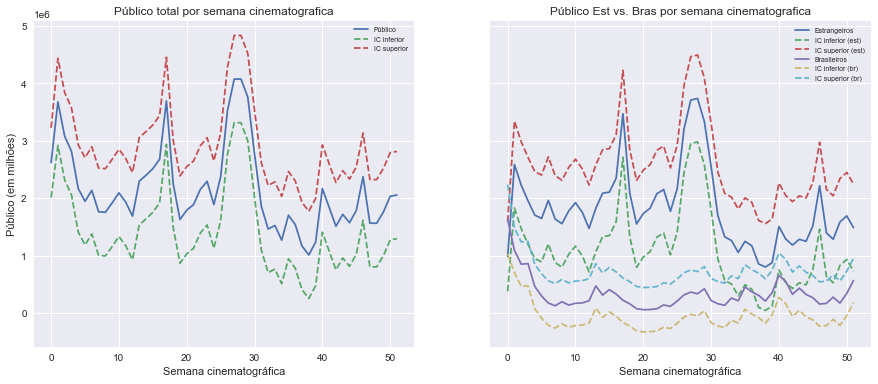

In [13]:
# plotando o gráfico de sazonalidade de público total e a sazonalidade de brasileiros vs. estrangeiros #

fig1, (ax11,ax12) = plt.subplots(1, 2, sharey=True, figsize=[15,6])

x_ind = np.arange(52)
reg = s1_res
reg1 = s2_res
reg2 = s3_res

plt.style.use('seaborn-bright')

ax11.plot(x_ind, reg.TOTAL_SEMANAL, label = 'Público')
ax11.plot(x_ind, reg.CI_low, linestyle='dashed', label = 'IC inferior')
ax11.plot(x_ind, reg.CI_high, linestyle='dashed', label = 'IC superior')

ax11.legend(fontsize = 'x-small')
ax11.set_title('Público total por semana cinematografica')
ax11.set_xlabel('Semana cinematográfica')
ax11.set_ylabel('Público (em milhões)')

ax12.plot(x_ind, reg1.TOTAL_SEMANAL, label = 'Estrangeiros')
ax12.plot(x_ind, reg1.CI_low, linestyle='dashed', label = 'IC inferior (est)')
ax12.plot(x_ind, reg1.CI_high, linestyle='dashed', label = 'IC superior (est)')

ax12.plot(x_ind, reg2.TOTAL_SEMANAL, label = 'Brasileiros')
ax12.plot(x_ind, reg2.CI_low, linestyle='dashed', label = 'IC inferior (br)')
ax12.plot(x_ind, reg2.CI_high, linestyle='dashed', label = 'IC superior (br)')

ax12.legend(fontsize = 'x-small')
ax12.set_title('Público Est vs. Bras por semana cinematografica')
ax12.set_xlabel('Semana cinematográfica')

In [3]:
sadis_semanal.columns

Index(['CPB/ROE', 'TITULO_DA_OBRA', 'ANO_CINE', 'SEMANA_CINE',
       'ANO_LANCAMENTO', 'SEMANA_LANCAMENTO', 'LANC_NO_ANO', 'SEM_DSDE_LANC',
       'DATA_LANC', 'PAIS_ORIGEM', 'NACIONALIDADE', 'PUBLICO', 'RENDA',
       'SALAS_NO_LANCAMENTO', 'GENERO'],
      dtype='object')

## Público e renda por semanas depois do lançamento

In [7]:
# agrupando por obras e semanas desde o lançamento

semanal_filmes = sadis_semanal.groupby(['CPB/ROE','SEM_DSDE_LANC'], as_index=False).agg({
    'TITULO_DA_OBRA':'first','PUBLICO':'sum','RENDA':'sum','NACIONALIDADE':'first'
})

# fazendo loop para pegar apenas as obras que tem pelo menos 8 semanas consecutivas de bilheteria pós lançamento
# isto é, obras com algum porte mínimo

idx = []

for i in semanal_filmes['CPB/ROE'].unique():
    sem = semanal_filmes[semanal_filmes['CPB/ROE'] == i].SEM_DSDE_LANC
    if sem.nunique() >= 11:
        for n in range(11):
            if n not in sem.unique():
                break
        else:
            idx.extend(sem.index)
            
filmes = semanal_filmes.iloc[idx].query("SEM_DSDE_LANC <= 9 & SEM_DSDE_LANC >= 0")
filmes.reset_index(inplace=True)

# obtendo colunas com a renda e público percentuais do total por semana desde o lançamento

norm = semanal_filmes.iloc[idx].query("SEM_DSDE_LANC >= 0").groupby(['CPB/ROE']).agg({
    'PUBLICO':'sum','RENDA':'sum'
})

for i in range(filmes.shape[0]):
    filmes.loc[i,'PUBLICO_NORM'] = filmes.loc[i,'PUBLICO'] / norm.loc[filmes.loc[i,'CPB/ROE'],'PUBLICO']
    filmes.loc[i,'RENDA_NORM'] = filmes.loc[i,'RENDA'] / norm.loc[filmes.loc[i,'CPB/ROE'],'RENDA']

In [8]:
# regredindo e rodando os resultados da semana

reg1 = smf.ols(formula='PUBLICO_NORM ~ C(SEM_DSDE_LANC)', data=filmes.query("NACIONALIDADE == 'Estrangeira'")).fit()
reg2 = smf.ols(formula='PUBLICO_NORM ~ C(SEM_DSDE_LANC)', data=filmes.query("NACIONALIDADE == 'Brasileira'")).fit()
reg3 = smf.ols(formula='RENDA_NORM ~ C(SEM_DSDE_LANC)', data=filmes.query("NACIONALIDADE == 'Estrangeira'")).fit()
reg4 = smf.ols(formula='RENDA_NORM ~ C(SEM_DSDE_LANC)', data=filmes.query("NACIONALIDADE == 'Brasileira'")).fit()

res1 = pd.read_html(reg1.summary().tables[1].as_html(),header=0,index_col=0)[0]
res2 = pd.read_html(reg2.summary().tables[1].as_html(),header=0,index_col=0)[0]
res3 = pd.read_html(reg3.summary().tables[1].as_html(),header=0,index_col=0)[0]
res4 = pd.read_html(reg4.summary().tables[1].as_html(),header=0,index_col=0)[0]

for r in [(reg1,res1), (reg2,res2), (reg3,res3), (reg4,res4)]:
    icpt = r[1].iloc[0,0]
    r[1].loc[:,'CI_low'], r[1].loc[:,'CI_high'] = (r[0].conf_int(alpha=0.05).iloc[:,0]+icpt), (r[0].conf_int(alpha=0.05).iloc[:,1]+icpt)
    r[1].loc[:,'Estimate'] = r[1].coef + icpt
    r[1].loc['Intercept','Estimate'] = r[1].loc['Intercept','Estimate'] - icpt
    r[1].loc['Intercept','CI_low'] = r[1].loc['Intercept','CI_low'] - icpt
    r[1].loc['Intercept','CI_high'] = r[1].loc['Intercept','CI_high'] - icpt
    
# criando coluna do resto

for d in [res1, res2, res3, res4]:
    d.loc['T.10.0','Estimate'] = 1 - d.Estimate.sum()

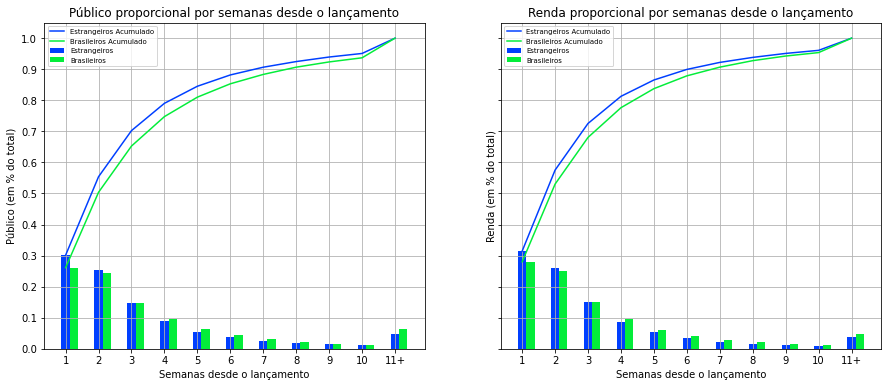

In [9]:
# plotando o gráfico de sazonalidade de público total e a sazonalidade de brasileiros vs. estrangeiros #

fig1, (ax11,ax12) = plt.subplots(1, 2, sharey=True, figsize=[15,6])

x_ind = np.arange(11)
reg = res1
reg1 = res2
reg2 = res3
reg3 = res4

width = 0.25

plt.style.use('seaborn-bright')

ax11.plot(x_ind, reg.Estimate.cumsum(), label = 'Estrangeiros Acumulado')
ax11.plot(x_ind, reg1.Estimate.cumsum(), label = 'Brasileiros Acumulado')

ax11.bar(x_ind, reg.Estimate, label = 'Estrangeiros', width=width)
#ax11.plot(x_ind, reg.CI_low, linestyle='dashed', label = 'IC inferior (est)')
#ax11.plot(x_ind, reg.CI_high, linestyle='dashed', label = 'IC superior (est)')

ax11.bar(x_ind + width, reg1.Estimate, label = 'Brasileiros', width=width)
#ax11.plot(x_ind, reg2.CI_low, linestyle='dashed', label = 'IC inferior (bras)')
#ax11.plot(x_ind, reg2.CI_high, linestyle='dashed', label = 'IC superior (bras)')

ax11.legend(fontsize = 'x-small')
ax11.set_title('Público proporcional por semanas desde o lançamento')
ax11.set_xlabel('Semanas desde o lançamento')
ax11.set_ylabel('Público (em % do total)')

ax12.bar(x_ind, reg2.Estimate, label = 'Estrangeiros',width=width)
#ax12.plot(x_ind, reg2.CI_low, linestyle='dashed', label = 'IC inferior (est)')
#ax12.plot(x_ind, reg2.CI_high, linestyle='dashed', label = 'IC superior (est)')

ax12.bar(x_ind + width, reg3.Estimate, label = 'Brasileiros', width=width)
#ax12.plot(x_ind, reg3.CI_low, linestyle='dashed', label = 'IC inferior (br)')
#ax12.plot(x_ind, reg3.CI_high, linestyle='dashed', label = 'IC superior (br)')

ax12.plot(x_ind, reg2.Estimate.cumsum(), label = 'Estrangeiros Acumulado')
ax12.plot(x_ind, reg3.Estimate.cumsum(), label = 'Brasileiros Acumulado')

ax12.legend(fontsize = 'x-small')
ax12.set_title('Renda proporcional por semanas desde o lançamento')
ax12.set_xlabel('Semanas desde o lançamento')
ax12.set_ylabel('Renda (em % do total)')
ax11.grid(True)
ax12.grid(True)
ticks = [x+1 for x in range(10)]
ticks.append('11+')
ax11.set_xticks(x_ind)
ax12.set_xticks(x_ind)
ax11.set_xticklabels(ticks)
ax12.set_xticklabels(ticks)
plt.yticks([x/10 for x in range(11)])
plt.show()

In [71]:
# testando para ver se diferença é significativa (esse teste está errado)

from scipy.stats import chi2_contingency

stat_bras = filmes.query("NACIONALIDADE == 'Brasileira'").groupby('SEM_DSDE_LANC').agg({'PUBLICO':'sum','RENDA':'sum'})
stat_est = filmes.query("NACIONALIDADE == 'Estrangeira'").groupby('SEM_DSDE_LANC').agg({'PUBLICO':'sum','RENDA':'sum'})


arpub = np.array([stat_bras.PUBLICO, stat_est.PUBLICO])
arrend = np.array([stat_bras.RENDA, stat_est.RENDA])

_, p1, dof1, _ = chi2_contingency(arpub)
_, p2, dof2, _ = chi2_contingency(arrend)

df = pd.DataFrame({'p-value': [p1,p2], 'DoF':[dof1,dof2]}, index=['Público','Renda'])

## Médias de ocupação por semanas após o lançamento

In [3]:
# agora vamos lidar com a ocupação por semana pós estreia dos filmes

scb_trab = pd.read_csv('SCB_2017 a 2019 tratado 2.csv')

In [5]:
scb_trab.dtypes

ANO_CINEMATOGRAFICO          int64
SEMANA_CINEMATOGRAFICA       int64
PRIMEIRO_DIA_SEMANA         object
ULTIMO_DIA_SEMANA           object
DATA_SESSAO                 object
DIA_SEMANA                  object
QUALIFICADOR_DIA_SEMANA     object
HORA_SESSAO                 object
DATA_HORA_SESSAO            object
TIPO_SESSAO                 object
REGISTRO_SALA              float64
REGISTRO_COMPLEXO          float64
CPB_ROE                     object
TITULO                      object
NACIONALIDADE               object
PUBLICO                      int64
RENDA                      float64
QT_ASSENTOS_SALA           float64
GRUPO_EXIBIDOR              object
CEP_COMPLEXO                object
TOT_SALAS_FUNC               int64
COMERCIAL                   object
REG_EMPRESA                  int64
AGE                         object
QTD_ASSENTOS_GRUPO         float64
QTD_SALAS_GRUPO              int64
QTD_COMPLEXOS_GRUPO          int64
OCUPAÇÃO_SALAS             float64
ANO_MES             

In [5]:
# agrupando só sessões regulares por CPB/ROE, ano e semana, para depois poder achar as médias de ocupação por semana

scb_semanal = scb_trab.query("TIPO_SESSAO == 'SESSÃO REGULAR'").groupby(
    ['CPB_ROE','ANO_CINEMATOGRAFICO','SEMANA_CINEMATOGRAFICA']).agg({
    'TITULO':'first','NACIONALIDADE':'first','PUBLICO':'sum','RENDA_ATUALIZADA_JAN20':'sum',
    'QT_ASSENTOS_SALA':'sum','ASSENTOS_INFERIDO':'sum',
    'OCUPAÇÃO_SALAS':'mean','OCUPAÇÃO_SALA_INFERIDA':'mean'
})

In [6]:
# achando obras que tem pelo menos 10 semanas de exibição em salas

idx = []

for r in scb_trab.query("TIPO_SESSAO == 'SESSÃO REGULAR'").CPB_ROE.unique():
        if len(scb_semanal.loc[r].index) >= 10:
            idx.append(r)

In [7]:
# usando loop para criar a coluna de semanas desde o lançamento usando a data de público máximo como referência para 
# a semana de lançamento

for r in idx:
    arg_max = scb_semanal.loc[r].PUBLICO.argmax()
    ano_max, sem_max = scb_semanal.loc[r].index[arg_max]
    rang = len(scb_semanal.loc[r].index[arg_max:])
    for i in range(arg_max, arg_max+rang):
        ano = scb_semanal.loc[r].index[i][0]
        sem = scb_semanal.loc[r].index[i][1]
        if ano == ano_max:
            scb_semanal.loc[(r,ano,sem),'SEM_DSDE_LANC'] = sem - sem_max
        elif ano == ano_max + 1:
            scb_semanal.loc[(r,ano,sem),'SEM_DSDE_LANC'] = sem + 52 - sem_max
        else:
            scb_semanal.loc[(r,ano,sem),'SEM_DSDE_LANC'] = sem + 104 - sem_max

In [8]:
# criando o conceito de lotação total da semana dividindo assentos disponibilizados vs. publico naquele ínterim

scb_semanal['LOTAÇÃO_TOTAL'] = np.divide(scb_semanal['PUBLICO'], scb_semanal['ASSENTOS_INFERIDO'])

# agrupando por semana desde o lançamento

sem_dsde_lanc = scb_semanal[scb_semanal.SEM_DSDE_LANC.notna()].groupby(['SEM_DSDE_LANC']).agg({
    'OCUPAÇÃO_SALA_INFERIDA':['mean','median'], 'LOTAÇÃO_TOTAL':['mean','median']
})

In [9]:
# calculando valor para as 11 primeiras semanas + resto, para média e mediana

sem_dsde_lanc10 = sem_dsde_lanc.loc[:10]

sem_dsde_lanc10.loc[11,('OCUPAÇÃO_SALA_INFERIDA','median')] = sem_dsde_lanc.loc[10:,('OCUPAÇÃO_SALA_INFERIDA','median')].median()
sem_dsde_lanc10.loc[11,('OCUPAÇÃO_SALA_INFERIDA','mean')] = sem_dsde_lanc.loc[10:,('OCUPAÇÃO_SALA_INFERIDA','mean')].mean()

sem_dsde_lanc10.loc[11,('LOTAÇÃO_TOTAL','mean')] = sem_dsde_lanc.loc[10:,('LOTAÇÃO_TOTAL','mean')].mean()
sem_dsde_lanc10.loc[11,('LOTAÇÃO_TOTAL','median')] = sem_dsde_lanc.loc[10:,('LOTAÇÃO_TOTAL','median')].median()

<ipython-input-9-5b8e5ece8e29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sem_dsde_lanc10.loc[11,('OCUPAÇÃO_SALA_INFERIDA','median')] = sem_dsde_lanc.loc[10:,('OCUPAÇÃO_SALA_INFERIDA','median')].median()


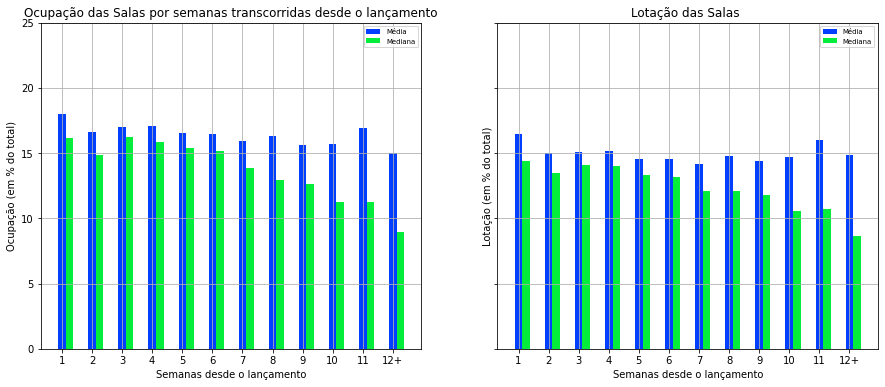

In [127]:
# plotando o gráfico ocupação média das salas por semana após o lancamento

fig1, (ax11,ax12) = plt.subplots(1, 2, sharey=True, figsize=[15,6])

x_ind = np.arange(12)

width = 0.25

plt.style.use('seaborn-bright')

ax11.bar(x_ind, sem_dsde_lanc10[('OCUPAÇÃO_SALA_INFERIDA','mean')], label = 'Média', width=width)

ax11.bar(x_ind + width, sem_dsde_lanc10[('OCUPAÇÃO_SALA_INFERIDA','median')], label = 'Mediana', width=width)

ax11.legend(fontsize = 'x-small')
ax11.set_title('Ocupação das Salas por semanas transcorridas desde o lançamento')
ax11.set_xlabel('Semanas desde o lançamento')
ax11.set_ylabel('Ocupação (em % do total)')

ax12.bar(x_ind,  sem_dsde_lanc10[('LOTAÇÃO_TOTAL','mean')], label = 'Média', width=width)

ax12.bar(x_ind + width, sem_dsde_lanc10[('LOTAÇÃO_TOTAL','median')], label = 'Mediana', width=width)

ax12.legend(fontsize = 'x-small')
ax12.set_title('Lotação das Salas ')
ax12.set_xlabel('Semanas desde o lançamento')
ax12.set_ylabel('Lotação (em % do total)')
ax11.grid(True)
ax12.grid(True)
ticks = [x+1 for x in range(11)]
ticks.append('12+')
ax11.set_xticks(x_ind)
ax12.set_xticks(x_ind)
ax11.set_xticklabels(ticks)
ax12.set_xticklabels(ticks)
ax11.set_yticks([x/20 for x in range(6)])
ax12.set_yticks([x/20 for x in range(6)])
ax11.set_yticklabels([x*5 for x in range(6)])
ax12.set_yticklabels([x*5 for x in range(6)])

plt.show()

In [10]:
# fazendo alteração para plotar violin plots com todos os dados semanais

semanal=scb_semanal[scb_semanal.SEM_DSDE_LANC.notna()][['SEM_DSDE_LANC','NACIONALIDADE','OCUPAÇÃO_SALA_INFERIDA']].reset_index()

# procedimento para pegar a média das ocupações para cada obra nas semanas acima de 10 depois do lançamento

dezmais = semanal.query("SEM_DSDE_LANC >= 10").groupby(['CPB_ROE']).agg({'OCUPAÇÃO_SALA_INFERIDA':'mean', 
                                                                         'NACIONALIDADE':'first'})
# descartando colunas desnecessárias

semanal.drop(['ANO_CINEMATOGRAFICO', 'SEMANA_CINEMATOGRAFICA'], inplace=True, axis=1)

# separando só as linhas com lançamentos a menos de 10 semanas de distância

semanal_res = semanal.query("SEM_DSDE_LANC < 10")

# finalmente apensando as colunas com mais de 10 usando o dataframe 10mais criado antes

for i, r in dezmais.iterrows():
    semanal_res = semanal_res.append({'CPB_ROE':i, 'SEM_DSDE_LANC':10, 'OCUPAÇÃO_SALA_INFERIDA':r['OCUPAÇÃO_SALA_INFERIDA'],
                                     'NACIONALIDADE':r['NACIONALIDADE']},
                      ignore_index=True, verify_integrity=True)

In [11]:
# fazendo o scatter plot com as médias
medias = semanal_res.groupby('SEM_DSDE_LANC',as_index=False).agg({'OCUPAÇÃO_SALA_INFERIDA':['mean','median']})

# e também separado por médias de brasileiros vs. estrangeiros
medias_br_est = semanal_res.groupby(['NACIONALIDADE','SEM_DSDE_LANC'],as_index=False).agg(
    {'OCUPAÇÃO_SALA_INFERIDA':['mean','median']})

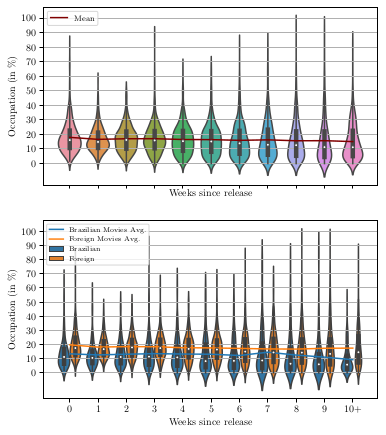

In [18]:
fig1, (ax11,ax21) = plt.subplots(2, 1, sharex=True, figsize=set_size(433.61))

x_ind = np.arange(11)

width = 0.25

sns.violinplot(ax=ax11, x='SEM_DSDE_LANC',y='OCUPAÇÃO_SALA_INFERIDA',data=semanal_res, scale_hue=False,
               scale='count', bw=0.3)

ax11.plot(x_ind, medias[('OCUPAÇÃO_SALA_INFERIDA','mean')], label='Mean', c='maroon')
#ax11.plot(x_ind, medias[('OCUPAÇÃO_SALA_INFERIDA','median')], label='Median', c='cornflowerblue')


sns.violinplot(ax=ax21, x='SEM_DSDE_LANC',y='OCUPAÇÃO_SALA_INFERIDA',data=semanal_res, hue='NACIONALIDADE')

ax21.plot(x_ind, medias_br_est[medias_br_est.NACIONALIDADE == 'BRASILEIRA'][('OCUPAÇÃO_SALA_INFERIDA','mean')],
         label='Brazilian Movies Avg.')
ax21.plot(x_ind, medias_br_est[medias_br_est.NACIONALIDADE == 'ESTRANGEIRA'][('OCUPAÇÃO_SALA_INFERIDA','mean')],
         label='Foreign Movies Avg.')


ax11.legend(fontsize='small',loc='upper left')

handles, labels = ax21.get_legend_handles_labels()

ax21.legend(handles, ['Brazilian Movies Avg.', 'Foreign Movies Avg.', 'Brazilian', 'Foreign'], 
            fontsize='x-small',loc='upper left')

ax11.set_ylabel('Occupation (in %)')
ax21.set_ylabel('Occupation (in %)')
ax11.set_xlabel('Weeks since release')
ax21.set_xlabel('Weeks since release')

ax11.grid(True, axis='y')
ax21.grid(True, axis='y')


ticks = [x for x in range(10)]
ticks.append('10+')
ax11.set_xticks(x_ind)
ax21.set_xticks(x_ind)
ax11.set_xticklabels(ticks)
ax21.set_xticklabels(ticks)

ax11.set_yticks([x/10 for x in range(11)])
ax11.set_yticklabels([x*10 for x in range(11)])
ax21.set_yticks([x/10 for x in range(11)])
ax21.set_yticklabels([x*10 for x in range(11)])

plt.savefig('Violinplots - Occupation.pgf', format='pgf')
# plt.show()


# INSPECTION DATA (Source: Inspection Reports/Ancine)

*Os relatórios de fiscalização são as apurações anuais da Cota de Tela realizadas pelo setor responsável pela fiscalização da Ancine.*

*As apurações são públicas e estão [disponíveis](https://www.gov.br/ancine/pt-br/assuntos/atribuicoes-ancine/fiscalizacao/cinema) no sítio eletrônico da Agência.*

A seguir, importo uma base já tratada que incorpora dados de fiscalização de 2017 e 2018, dado que no ano de 2019 não houve cota de tela vigente.

## Data import

In [84]:
# importação da base pré-tratada #

cota = pd.read_csv('Cota_fiscalizacao_2017_2019.csv', index_col=['REGISTRO DO COMPLEXO'])

cota = cota[cota['CUMPRIU COTA'] != 'FORA DO ESCOPO DE AFERIÇÃO']

## Graph: non-compliance by type of obligation (day/title requirement)

In [16]:
# para criar gráfico para ver razão do descumprimento

def cota_dia(r):
    if r['CUMPRIMENTO_PROPORCIONAL'] >= 1:
        return True
    else:
        return False
    
def cota_tit(r):    
    if r['Nº DE TÍTULOS DIFERENTES DECLARADOS'] == 'SEM ENVIO VÁLIDO NO SCB':
        return False
    else:
        if int(r['Nº DE TÍTULOS DIFERENTES DECLARADOS']) >= int(r['Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO']):
            return True
        else:
            return False
            
cota['COTA_DIA'] = cota.apply(cota_dia, axis=1)
cota['COTA_TIT'] = cota.apply(cota_tit, axis=1)

In [17]:
cumpridores = (cota['CUMPRIU COTA'] == 'SIM').sum()
descumpridores = (cota['CUMPRIU COTA'] == 'NÃO').sum()
ddois = ((cota['COTA_DIA'] == False)&(cota['COTA_TIT'] == False)&(cota['CUMPRIU COTA'] == 'NÃO')).sum()
ddia = ((cota['COTA_DIA'] == False)&(cota['CUMPRIU COTA'] == 'NÃO')).sum() - ddois
dtit = ((cota['COTA_TIT'] == False)&(cota['CUMPRIU COTA'] == 'NÃO')).sum() - ddois

In [18]:
cota['CUMPRIU COTA'] = cota['CUMPRIU COTA'].map({'SIM':'Yes', 'NÃO':'No'})

cota.rename({'CUMPRIU COTA': 'SQ fulfillment', 'CUMPRIMENTO_PROPORCIONAL':'Day-Quota Fulfillment',
            'TOTAL SALAS DO COMPLEXO':'No. of viewing rooms per movie theater'}, axis=1, inplace=True)

In [5]:
cota['CUMPRIU COTA'].unique()

array(['NÃO', 'SIM'], dtype=object)

In [9]:
plt.figure(figsize=set_size(300))

x = np.arange(2)

plt.bar(x, [cumpridores, 0], label="Compliant", width=0.6)
plt.bar(x, [0, ddia], label="SQ Day-Noncompliant", width=0.6)
plt.bar(x, [0, ddois], label="SQ Day and Title-Noncompliant", width=0.6, bottom=[0,ddia])
plt.bar(x, [0, dtit], label="SQ Title-Noncompliant", width=0.6, bottom=[0,ddois+ddia])


plt.legend(loc='lower left')
plt.xticks(x, ['Compliant','Noncompliant'])
plt.ylabel('No. of Multiplexes')
plt.grid(True)


plt.annotate(cumpridores,(0,cumpridores-70), textcoords="offset points", xytext=(0,5),ha='center')
plt.annotate(ddia,(1,ddia-70), textcoords="offset points", xytext=(0,5),ha='center')
plt.annotate(ddois,(1,ddois+ddia-70), textcoords="offset points", xytext=(0,5),ha='center')
plt.annotate(dtit,(1,dtit+ddia+ddois-10), textcoords="offset points", xytext=(0,5),ha='center')

plt.savefig('Cota_descumprimento.pgf', format='pgf')

In [4]:
cota.iloc[:10,5:]

,TOTAL SALAS DO COMPLEXO,Nº DE DIAS OBRIGAÇÃO PROPORCIONAL,OBRIGAÇÃO_TOTAL+INCREMENTO,OBRIGAÇÃO_PROP+INCREMENTO,OBRIGAÇÃO_TOTAL,OBG_FINAL,Nº DE DIAS VALIDADOS,Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO,Nº DE TÍTULOS DIFERENTES DECLARADOS,CUMPRIU COTA,...,TRANSFERÊNCIA Dias Recebidos,OBRIGAÇÃO_TOTAL_POR_SALA,OBRIGAÇÃO_TOTAL+INCREMENTO_POR_SALA,OBRIGAÇÃO_PROP_POR_SALA,OBRIGAÇÃO_PROP+INCREMENTO_POR_SALA,OBRIGAÇÃO_FINAL_POR_SALA,CUMPRIMENTO_PROPORCIONAL,DIAS_FUNC_INFERIDOS,CUMPRIMENTO_PROP_TRUNCADO,CUMPRIMENTO_NORMALIZADO
REGISTRO DO COMPLEXO,,,,,,,,,,,,,,,,,,,,,
14061,3,126.000000,126.0,126.000000,126,126.00,83.5,5,12,NÃO,...,0.0,42.0,42.00,42.000000,42.000000,42.000000,0.662698,365.000000,0.886228,0.376881
18367,4,195.999989,197.0,196.999989,196,197.00,121.0,6,14,NÃO,...,0.0,49.0,49.25,48.999997,49.249997,49.250000,0.614213,364.999980,0.851169,0.370332
27434,5,280.000000,281.5,281.500000,280,281.50,130.5,8,16,NÃO,...,0.0,56.0,56.30,56.000000,56.300000,56.300000,0.463588,365.000000,0.712262,0.345485
28475,3,126.000000,126.0,126.000000,126,126.00,76.0,5,11,NÃO,...,0.0,42.0,42.00,42.000000,42.000000,42.000000,0.603175,365.000000,0.842530,0.368736
38005,3,16.224660,126.0,16.224660,126,16.22,11.5,5,2,NÃO,...,0.0,42.0,42.00,5.408220,5.408220,5.406667,0.709001,47.000007,0.915320,0.382404
34408,5,280.000000,280.0,280.000000,280,280.00,164.5,8,16,NÃO,...,0.0,56.0,56.00,56.000000,56.000000,56.000000,0.587500,365.000000,0.829844,0.366405
24026,1,28.000000,28.0,28.000000,28,28.00,13.5,3,3,NÃO,...,0.0,28.0,28.00,28.000000,28.000000,28.000000,0.482143,365.000000,0.731824,0.348880
32422,2,69.999996,70.0,69.999996,70,70.00,43.5,4,7,NÃO,...,0.0,35.0,35.00,34.999998,34.999998,35.000000,0.621429,364.999979,0.856684,0.371355
35405,3,126.000000,126.0,126.000000,126,126.00,3.5,5,3,NÃO,...,0.0,42.0,42.00,42.000000,42.000000,42.000000,0.027778,365.000000,0.054784,0.248690


## Graph: screen quota throughout exec orders

In [2]:
# importando decretos para fazer plot da obrigação por sala em função do tamanho do complexo

decreto18 = pd.read_excel('Decreto cota de tela 2017-2018.xlsx', index_col=0)
decreto13 = pd.read_excel('Decreto cota de tela 2007-2013.xlsx', index_col=0)
decreto06 = pd.read_excel('Decreto cota de tela 2005-2006.xlsx', index_col=0)

decreto06 = decreto06[:11]
decreto18 = decreto18[:20]


for i in range(12,21):
    decreto06 = decreto06.append({'NÚMERO DE DIAS DE OBRIGATORIEDADE':i+7*(i-11)+462,'EXIBIÇÃO DIFERENCIADA MÍNIMA DE TÍTULOS':1},ignore_index=True)

decreto18['OBG_PROP'] = decreto18['Cota por complexo'] / range(1,21)
decreto13['OBG_PROP'] = decreto13['Cota por Complexo'].astype(int) / range(1,21)
decreto06['OBG_PROP'] = decreto06['NÚMERO DE DIAS DE OBRIGATORIEDADE'].astype(int) / range(1,21)

In [7]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

x = range(1,21)

plt.figure(figsize=set_size(433.62))

plt.plot(x, decreto18['OBG_PROP'], label="2014 to 2018", marker='o', markersize=4)
plt.plot(x, decreto13['OBG_PROP'], label="2007 to 2013", marker='o', markersize=4, linestyle='dashed')
plt.plot(x, decreto06['OBG_PROP'], label="2005 to 2006", marker='o', markersize=4, linestyle='dotted')

plt.legend()
plt.xticks(x)
plt.xlabel('No. of viewing rooms per movie theater')
plt.ylabel('No. of screen quota days per viewing room')
plt.grid(True)

for x,y in zip(x,decreto18['OBG_PROP'].values):
    lab=int(y)
    
    plt.annotate(lab,(x,y), textcoords="offset points", xytext=(0,5),ha='right')
plt.savefig('Cota_por_sala.pgf', format='pgf')    
plt.show()


<ipython-input-7-43cda766ba78>:30: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


A obrigação total é calculada com base no decreto publicado anualmente.

A obrigação proporcional é calculada tendo como base o número de dias de funcionamento do complexo com base em informações do SAD/Ancine.

A obrigação final (OBG_FINAL) é calculada a partir da obrigação proporcional, levando-se em conta os incrementos do [art. 3º-A, da Instrução Normativa nº 117 da Ancine](https://antigo.ancine.gov.br/pt-br/legislacao/instrucoes-normativas-consolidadas/instru-o-normativa-n-117-de-31-de-dezembro-de-2014), relativos à *. Os incrementos também são somados à obrigação total e proporcional das salas para obter uma medida das respectivas obrigações com incrementos.

A obrigação final leva em conta ainda as transferências de obrigação entre salas de uma mesma empresa ou grupo, previstos na [IN 88, art. 3º](https://antigo.ancine.gov.br/pt-br/legislacao/instrucoes-normativas-consolidadas/instru-o-normativa-n-88-de-2-de-mar-o-de-2010) e [IN 151, art. 5º](https://www.in.gov.br/en/web/dou/-/instrucao-normativa-n-151-de-22-de-janeiro-de-2020-239633692#:~:text=Regulamenta%20o%20cumprimento%20e%20a,comercial%2C%20e%20d%C3%A1%20outras%20provid%C3%AAncias.)

As obrigações por sala são sempre obtidas pegando a obrigação respectiva e dividindo-a pelo número de salas do complexo, na coluna correspondente.

A coluna cumprimento proporcional é simplesmente a razão entre nº de dias validados e obrigação final.

Os dias de funcionamento inferidos são obtidos da seguinte forma: $ DF = 365 \cdot \frac{Obg \, prop}{Obg \, total} $.

Para aferir a sensibilidade do problema da firma à cota, sendo que o máximo ocorre quando a obrigação é cumprida exatamente, diminuindo conforme a total de dias exibidos se afasta da obrigação total da sala, para cima e para baixo. Por exemplo, para uma sala que cumpre 10x o nº de dias devidos, a restrição dos dias não deve ser ativa. Para uma sala que descumpre a cota totalmente, o custo de passar os filmes brasileiros é tão grande que descumprir a cota compensa, de modo que ela deveria não passar os filmes brasileiros mesmo na ausência da cota.

A função escolha nessa especificação deve ter o máximo em $1$ e declinar para os lados conforme se afasta desse valor. Um candidato natural é uma função quadrática que basicamente mede a distância para $1$: $$d(x) = \max\{0, 1 - (1 - x)^2\} $$ Note que o argumento, $x$, é o cumprimento proporcional da obrigação, definido logo acima como a razão entre *dias validados de exibição de filmes brasileiros* e o *número de dias de obrigação proporcional*.

Para evitar valores negativos, é preciso colocar um piso para a função em 0. Naturalmente, essa escolha gera que a função é simétrica entre 0 e 2 em torno de um, e nula para valores maiores.

Isso levanta questões sobre a escolha arbitrária da forma funcional. Para tentar algum tipo de robustez, propomos uma especificação alternativa com a função de densidade de uma normal $N(1,1)$.

## Scattersplots of SQ, fulfillment and multiplex size, with transfers

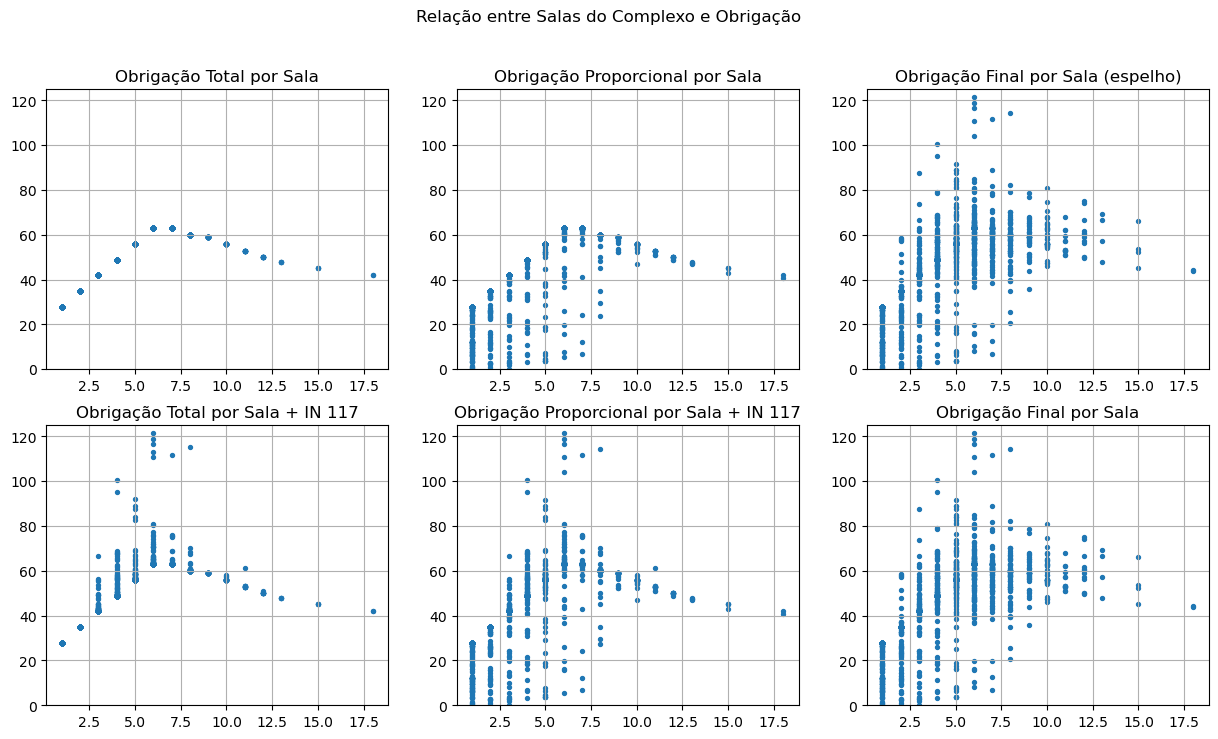

In [5]:
# plotando alguns gráficos para ilustrar transformações de obrigações conforme etapas da cota são apuradas
# obrigação total por sala, depois acréscimos da IN 117, depois proporcionalidade por dias de func no SAD e finalmente
# transferências de obrigação

plt.style.use('default')

size = 8

cota_redux = cota[cota.OBRIGAÇÃO_FINAL_POR_SALA.notna()]

fig2, ax = plt.subplots(2, 3, figsize=[15,8])

fig2.suptitle('Relação entre Salas do Complexo e Obrigação')

ax[1,0].scatter(x=cota_redux['TOTAL SALAS DO COMPLEXO'], y=cota_redux['OBRIGAÇÃO_TOTAL+INCREMENTO_POR_SALA'], s=size)
ax[1,0].set_title('Obrigação Total por Sala + IN 117')
ax[1,0].grid()

ax[1,1].scatter(x=cota_redux['TOTAL SALAS DO COMPLEXO'], y=cota_redux['OBRIGAÇÃO_PROP+INCREMENTO_POR_SALA'],s=size)
ax[1,1].set_title('Obrigação Proporcional por Sala + IN 117')
ax[1,1].grid()

ax[1,2].scatter(x=cota_redux['TOTAL SALAS DO COMPLEXO'], y=cota_redux['OBRIGAÇÃO_FINAL_POR_SALA'],s=size)
ax[1,2].set_title('Obrigação Final por Sala')
ax[1,2].grid()

ax[0,0].scatter(x=cota_redux['TOTAL SALAS DO COMPLEXO'], y=cota_redux['OBRIGAÇÃO_TOTAL_POR_SALA'],s=size)
ax[0,0].set_title('Obrigação Total por Sala')
ax[0,0].grid()

ax[0,1].scatter(x=cota_redux['TOTAL SALAS DO COMPLEXO'], y=cota_redux['OBRIGAÇÃO_PROP_POR_SALA'],s=size)
ax[0,1].set_title('Obrigação Proporcional por Sala')
ax[0,1].grid()

ax[0,2].scatter(x=cota_redux['TOTAL SALAS DO COMPLEXO'], y=cota_redux['OBRIGAÇÃO_FINAL_POR_SALA'],s=size)
ax[0,2].set_title('Obrigação Final por Sala (espelho)')
ax[0,2].grid()

for i in range(2):
    for j in range(3):
        ax[i,j].set_yticks(range(0,130,20))
        ax[i,j].set_ylim([0,125])

Text(0.5, 1.0, 'Cumprimento Proporcional Truncado vs. Total de Salas do Complexo')

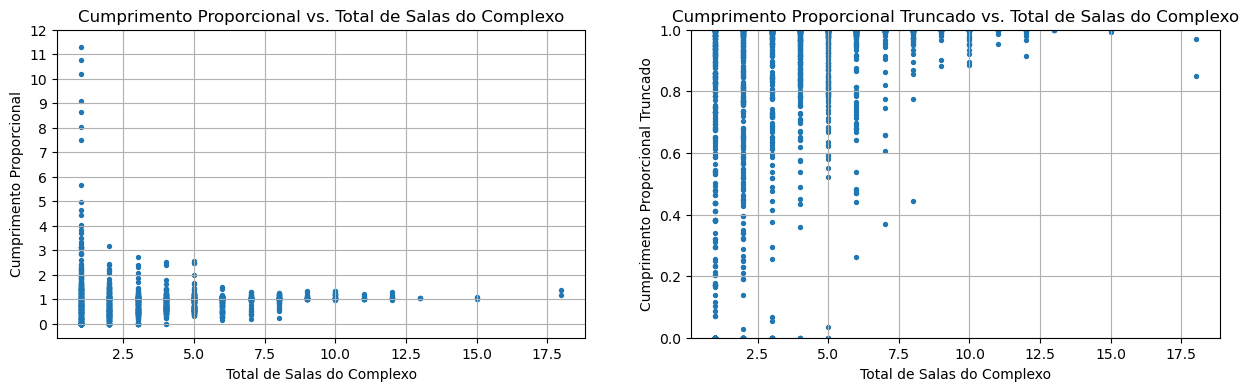

In [8]:
# plotando gráficos para ilustrar relação entre cumprimento de obrigação e tamanho dos complexos

cota_redux2 = cota[cota.CUMPRIMENTO_PROPORCIONAL.notna()]
size = 8

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))

ax1.scatter(x=cota_redux2['TOTAL SALAS DO COMPLEXO'], y=cota_redux2['CUMPRIMENTO_PROPORCIONAL'], s=size)
ax1.set_xlabel('Total de Salas do Complexo')
ax1.set_ylabel('Cumprimento Proporcional')
ax1.set_yticks(range(0,13,1))
ax1.grid()
ax1.set_title('Cumprimento Proporcional vs. Total de Salas do Complexo')


ax2.scatter(x=cota_redux2['TOTAL SALAS DO COMPLEXO'], y=cota_redux2['CUMPRIMENTO_PROP_TRUNCADO'], s=size)
ax2.set_xlabel('Total de Salas do Complexo')
ax2.set_ylabel('Cumprimento Proporcional Truncado')
ax2.set_ylim(0,1)
ax2.grid()
ax2.set_title('Cumprimento Proporcional Truncado vs. Total de Salas do Complexo')


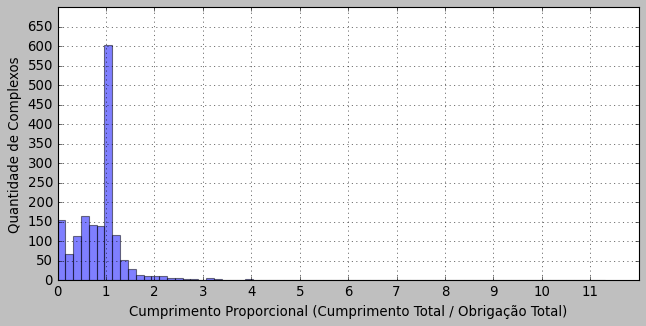

In [15]:
# histograma de cumprimento proporcional apenas

plt.style.use('classic')


plt.figure(figsize=(8,4))
plt.hist(cota_redux2['CUMPRIMENTO_PROPORCIONAL'], bins=70, alpha=0.5, ec='black')
plt.grid()
plt.xticks(range(0,12,1))
plt.yticks(range(0,700,50))
plt.tight_layout()
plt.ylabel("Quantidade de Complexos")
plt.xlabel("Cumprimento Proporcional (Cumprimento Total / Obrigação Total)")

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

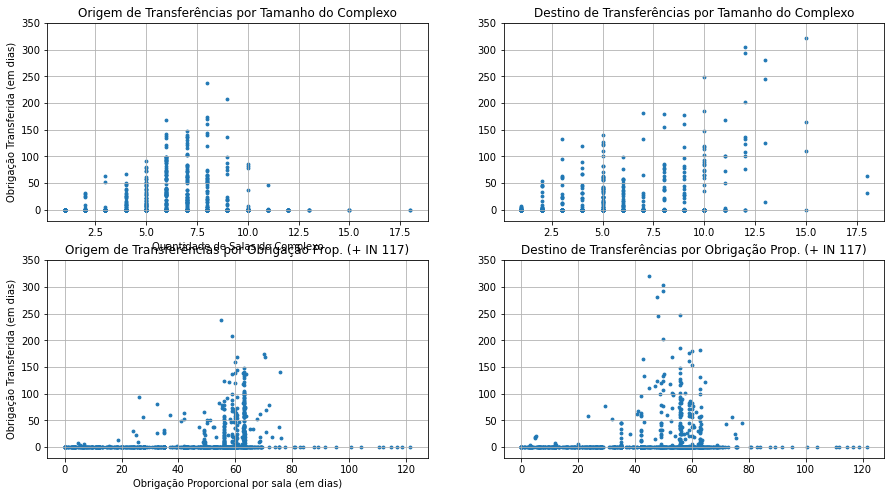

In [14]:
# gráfico de dispersão relacionando transferências com tamanho do complexo #

size = 8

fig, ax = plt.subplots(2,2, figsize=(15,8))

ax[0,0].scatter(x=cota['TOTAL SALAS DO COMPLEXO'], y=cota['TRANSFERÊNCIA Dias Origem'], s=8)
ax[0,0].set_title("Origem de Transferências por Tamanho do Complexo")
ax[0,0].grid(True)
ax[0,0].set_ylim(-20,350)
ax[0,0].set_ylabel("Obrigação Transferida (em dias)")
ax[0,0].set_xlabel("Quantidade de Salas do Complexo")


ax[0,1].scatter(x=cota['TOTAL SALAS DO COMPLEXO'], y=cota['TRANSFERÊNCIA Dias Recebidos'], s=8)
ax[0,1].set_title("Destino de Transferências por Tamanho do Complexo")
ax[0,1].grid(True)
ax[0,1].set_ylim(-20,350)

ax[1,0].scatter(x=cota['OBRIGAÇÃO_PROP+INCREMENTO_POR_SALA'], y=cota['TRANSFERÊNCIA Dias Origem'], s=8)
ax[1,0].set_title("Origem de Transferências por Obrigação Prop. (+ IN 117)")
ax[1,0].grid(True)
ax[1,0].set_ylim(-20,350)
ax[1,0].set_xlabel("Obrigação Proporcional por sala (em dias)")
ax[1,0].set_ylabel("Obrigação Transferida (em dias)")

ax[1,1].scatter(x=cota['OBRIGAÇÃO_PROP+INCREMENTO_POR_SALA'], y=cota['TRANSFERÊNCIA Dias Recebidos'], s=8)
ax[1,1].set_title("Destino de Transferências por Tamanho do Complexo")
ax[1,1].grid(True)
ax[1,1].set_title("Destino de Transferências por Obrigação Prop. (+ IN 117)")

ax[1,1].set_ylim(-20,350)

plt.show

In [ ]:
# NOTA: acrescentar barplot com cumprimento vs. não cumprimento por total de salas do complexo

## Hist/scatter pairplot multiplexes vs. prop fulfillment

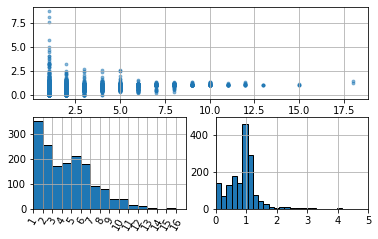

In [39]:
fig = plt.figure(figsize=set_size(433.62))

gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, :])

ax1.hist(cota['TOTAL SALAS DO COMPLEXO'], edgecolor='black', bins=17)
ax1.set_xticks(range(1,17))
ax1.tick_params(axis='x', rotation=60)
ax1.set_xlim(1,17)
ax2.set_ylim(0,500)
ax1.grid(True)

ax2.hist(cota['CUMPRIMENTO_PROPORCIONAL'], edgecolor='black',bins=50)
ax2.set_xlim(0,5)
ax2.set_ylim(0,500)
ax2.grid(True)

ax3.scatter(x=cota['TOTAL SALAS DO COMPLEXO'], y=cota['CUMPRIMENTO_PROPORCIONAL'], s=8, alpha=0.5)
ax3
ax3.grid(True)



plt.show()

In [85]:
cota['CUMPRIU COTA'] = cota['CUMPRIU COTA'].map({'NÃO':'No', 'SIM':'Yes'})

REGISTRO DO COMPLEXO
14061     No
18367     No
27434     No
28475     No
38005     No
        ... 
16523     No
24512    Yes
37811    Yes
14883     No
37751    Yes
Name: CUMPRIU COTA, Length: 1632, dtype: object

In [86]:
cota.rename({'CUMPRIU COTA': 'SQ Compliant'}, axis=1, inplace=True)

<Figure size 348.692x348.692 with 0 Axes>

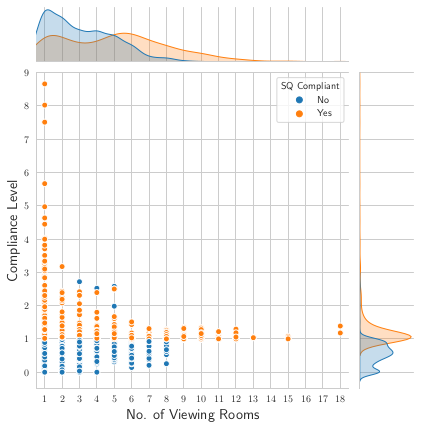

In [106]:
sns.set_style('whitegrid')

fig = plt.figure(figsize=set_size(350))

g = sns.jointplot(data=cota, x='TOTAL SALAS DO COMPLEXO', y='CUMPRIMENTO_PROPORCIONAL', hue='SQ Compliant')
g.set_axis_labels('No. of Viewing Rooms', 'Compliance Level', fontsize=14)
g.ax_joint.set_xticks(range(1,19))
g.ax_joint.set_xlim(0.5,18.5)
g.ax_joint.set_yticks(range(10))
g.ax_joint.set_ylim(-0.5,9)

plt.savefig('quota_compliance.pgf', format='pgf')

# SCB Database (Source: SCB/Ancine)

*The Ticket Control System (SCB) was implemented by Ancine in 2015 to receive box office data directly from exhibitors. In principle, these is exactly the same data as the one provided by distributors to SADIS.*

*The difference is that the reports received by SCB are even more granular, with data per session (not per day), and with revenue broken down by ticket category. More details about the system are available in the [Manual](https://www.gov.br/ancine/pt-br/assuntos/atribuicoes-ancine/regulacao/cinema/cota-de-tela/manual-cota-de-tela-22-02-2018.pdf/view)*

O Sistema de Controle de Bilheteria (SCB) foi implantado pela Ancine em 2015 para receber dados de bilheteria diretamente dos exibidores. Em princípio, são exatamente os mesmos dados que os fornecidos pelos distribuidores ao SADIS.

A diferença é que os relatórios recebidos pelo SCB são ainda mais granulares, com dados por sessão (e não por dia), e com receita discriminada por categoria de ingresso. Mais detalhes sobre o sistema estão disponíveis no [Manual](https://www.gov.br/ancine/pt-br/assuntos/atribuicoes-ancine/regulacao/cinema/cota-de-tela/manual-cota-de-tela-22-02-2018.pdf/view).

## Data import

In [2]:
scb_trab = pd.read_csv('SCB_2017 a 2019 tratado 2.csv', parse_dates=['DATA_HORA_SESSAO'])

In [3]:
scb_trab.columns

Index(['ANO_CINEMATOGRAFICO', 'SEMANA_CINEMATOGRAFICA', 'PRIMEIRO_DIA_SEMANA',
       'ULTIMO_DIA_SEMANA', 'DATA_SESSAO', 'DIA_SEMANA',
       'QUALIFICADOR_DIA_SEMANA', 'HORA_SESSAO', 'DATA_HORA_SESSAO',
       'TIPO_SESSAO', 'REGISTRO_SALA', 'REGISTRO_COMPLEXO', 'CPB_ROE',
       'TITULO', 'NACIONALIDADE', 'PUBLICO', 'RENDA', 'QT_ASSENTOS_SALA',
       'CEP_COMPLEXO', 'MUN_COMPLEXO', 'UF_COMPLEXO', 'TOT_SALAS_FUNC',
       'COMERCIAL', 'REG_EMPRESA', 'AGE', 'GRUPO_EXIBIDOR', 'OCUPAÇÃO_SALAS',
       'ANO_MES', 'FATOR', 'RENDA_ATUALIZADA_JAN20', 'REGISTRO_GRUPO',
       'ASSENTOS_INFERIDO', 'OCUPAÇÃO_SALA_INFERIDA', 'SALAS_GRUPO_INFERIDO',
       'SALAS_COMPLEXO_INFERIDO', 'ASSENTOS_COMPLEXO_INFERIDO',
       'ASSENTOS_GRUPO_INFERIDO', 'HORA_ajustada', 'DIAS_FUNCIONAMENTO',
       'DATA', 'DIAS_FUNCIONAMENTO_GRUPO', 'OBRIGAÇÃO_TOTAL_POR_SALA_GRUPO',
       'OBRIGAÇÃO_FINAL_POR_SALA_GRUPO', 'CUMPRIMENTO_PROPORCIONAL_GRUPO',
       'CUMPRIMENTO_PROP_TRUNCADO_GRUPO', 'CUMPRIMENTO_TRIWEIG

In [4]:
from datetime import datetime

# HH:MM format to session start info
scb_trab.loc[:,'HORA_SESSAO'] = scb_trab.loc[:,'HORA_SESSAO'].apply(lambda x: datetime.strptime(x, '%H:%M'))
scb_trab.loc[:,'HORA_COMECO_SESSAO'] = scb_trab.loc[:,'HORA_SESSAO'].apply(lambda x: x.hour) # getting col with starting hour

## Sessions, income, and moviegoers per day of the week

In [29]:
# used for all
std_dict = {'DATA_SESSAO': 'count', 'PUBLICO':'sum','RENDA_ATUALIZADA_JAN20':'sum'}

gby = ['DIA_SEMANA','NACIONALIDADE']

ridx = [6,7,12,13,2,3,4,5,8,9,10,11,0,1] # reorganize index to get weekdays ordered from monday to sunday

In [35]:
# used for section 3.2.1.

# group no. of sessions, income and moviegoers per nationality per weekday
sessoes_dia_semana = scb_trab.groupby(gby, as_index=False).agg(std_dict)

sessoes_dia_semana = sessoes_dia_semana.reindex(ridx)

In [36]:
# used for 3.2.2 and 3.2.3

# same only for 2017-2018

sessoes_dia_semana_17 = scb_trab.query("ANO_CINEMATOGRAFICO==2017").groupby(gby, as_index=False).agg(std_dict).reindex(ridx)

In [37]:
# used for 3.2.2 and 3.2.3

# same only for 2017-2018

sessoes_dia_semana_18 = scb_trab.query("ANO_CINEMATOGRAFICO==2018").groupby(gby, as_index=False).agg(std_dict).reindex(ridx)

In [38]:
# used for 3.2.2 and 3.2.3

# same only for 2019

sessoes_dia_semana_19 = scb_trab.query("ANO_CINEMATOGRAFICO==2019").groupby(gby, as_index=False).agg(std_dict).reindex(ridx)

In [39]:
# used in 3.2.3.2

filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR' & ANO_CINEMATOGRAFICO "

sessoes_comercial_17 = scb_trab.query(filt+'== 2017').groupby(gby, as_index=False).agg(std_dict).reindex(ridx)
sessoes_comercial_18 = scb_trab.query(filt+'== 2018').groupby(gby, as_index=False).agg(std_dict).reindex(ridx)
sessoes_comercial_19 = scb_trab.query(filt+'== 2019').groupby(gby, as_index=False).agg(std_dict).reindex(ridx)

### Preliminary: ranking according to inspection data

#### Ranking at chain-level

In [8]:
# import
cota_grupo = pd.read_csv('Cota_grupo_fiscalizacao_2017_2019.csv')

In [9]:
# create interaction columns between weighted compliance and magnitude of obligation
for c in cota_grupo.columns[-4:]:
    cota_grupo[f'OBG*{c}'] = np.multiply(cota_grupo[c], cota_grupo['OBRIGAÇÃO_FINAL_POR_SALA'])

In [55]:
# creating dictionaries with chain ids that are in the upper and lower bounds of interacted values

uppers = {}
lowers = {}

ut = 0.75 # upper threshold, used directly in graphs below
lt = 0.25 # lower threshold, same

for y in [2017,2018]:
    for c in cota_grupo.columns[-4:]:
        print(y, c) 
        queried = cota_grupo.query("ANO_CINEMATOGRAFICO == @y")
        print("Upper bound")
        print(queried[c].quantile(ut))
        print("Lower bound")
        print(queried[c].quantile(lt))
        uppers[f'{c[4:]}_{y}'] = queried[queried[c] > queried[c].quantile(ut)]['REGISTRO DO GRUPO'].to_list()
        lowers[f'{c[4:]}_{y}'] = queried[queried[c] < queried[c].quantile(lt)]['REGISTRO DO GRUPO'].to_list()

2017 OBG*CUMPRIMENTO_PROP_TRUNCADO
Upper bound
32.24201919586497
Lower bound
4.776785714285717
2017 OBG*CUMPRIMENTO_LINEAR
Upper bound
25.833333333333336
Lower bound
2.5000000000000004
2017 OBG*CUMPRIMENTO_NORMALIZADO
Upper bound
13.874999195252649
Lower bound
7.498245337683683
2017 OBG*CUMPRIMENTO_TRIWEIGHT
Upper bound
25.833333333333336
Lower bound
2.5000000000000004
2018 OBG*CUMPRIMENTO_PROP_TRUNCADO
Upper bound
38.463716407363236
Lower bound
6.483154215422639
2018 OBG*CUMPRIMENTO_LINEAR
Upper bound
32.849270833333335
Lower bound
3.5608333333333326
2018 OBG*CUMPRIMENTO_NORMALIZADO
Upper bound
16.412846008220786
Lower bound
8.468975358170017
2018 OBG*CUMPRIMENTO_TRIWEIGHT
Upper bound
32.849270833333335
Lower bound
3.5608333333333326


In [54]:
print(len(uppers['CUMPRIMENTO_PROP_TRUNCADO_2018']), len(lowers['CUMPRIMENTO_PROP_TRUNCADO_2018']))

61 61


In [56]:
filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR' & "

data = scb_trab[['ANO_CINEMATOGRAFICO','TIPO_SESSAO','COMERCIAL','REGISTRO_GRUPO','CUMPRIMENTO_PROP_TRUNCADO_GRUPO',
                'RENDA_ATUALIZADA_JAN20','PUBLICO','DATA_SESSAO','DIA_SEMANA','NACIONALIDADE']]

upper_concat = data.query(filt+"ANO_CINEMATOGRAFICO == 2017")[data.query(
    "ANO_CINEMATOGRAFICO == 2017")['REGISTRO_GRUPO'].apply(
    lambda x: x in uppers['CUMPRIMENTO_PROP_TRUNCADO_2017'])]

for y in [2018]:
    ano = data.query(filt+"ANO_CINEMATOGRAFICO == @y")
    ano = ano[ano['REGISTRO_GRUPO'].apply(lambda x: x in uppers[f'CUMPRIMENTO_PROP_TRUNCADO_{y}'])]
    upper_concat = pd.concat([upper_concat,ano], axis=0)
    
del ano
del filt

<ipython-input-56-9b725f09baec>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  upper_concat = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == 2017")[scb_trab.query(


In [66]:
scb_trab.columns

Index(['ANO_CINEMATOGRAFICO', 'SEMANA_CINEMATOGRAFICA', 'PRIMEIRO_DIA_SEMANA',
       'ULTIMO_DIA_SEMANA', 'DATA_SESSAO', 'DIA_SEMANA',
       'QUALIFICADOR_DIA_SEMANA', 'HORA_SESSAO', 'DATA_HORA_SESSAO',
       'TIPO_SESSAO', 'REGISTRO_SALA', 'REGISTRO_COMPLEXO', 'CPB_ROE',
       'TITULO', 'NACIONALIDADE', 'PUBLICO', 'RENDA', 'QT_ASSENTOS_SALA',
       'CEP_COMPLEXO', 'MUN_COMPLEXO', 'UF_COMPLEXO', 'TOT_SALAS_FUNC',
       'COMERCIAL', 'REG_EMPRESA', 'AGE', 'GRUPO_EXIBIDOR', 'OCUPAÇÃO_SALAS',
       'ANO_MES', 'FATOR', 'RENDA_ATUALIZADA_JAN20', 'REGISTRO_GRUPO',
       'ASSENTOS_INFERIDO', 'OCUPAÇÃO_SALA_INFERIDA', 'SALAS_GRUPO_INFERIDO',
       'SALAS_COMPLEXO_INFERIDO', 'ASSENTOS_COMPLEXO_INFERIDO',
       'ASSENTOS_GRUPO_INFERIDO', 'HORA_ajustada', 'DIAS_FUNCIONAMENTO',
       'DATA', 'DIAS_FUNCIONAMENTO_GRUPO', 'OBRIGAÇÃO_TOTAL_POR_SALA_GRUPO',
       'OBRIGAÇÃO_FINAL_POR_SALA_GRUPO', 'CUMPRIMENTO_PROPORCIONAL_GRUPO',
       'CUMPRIMENTO_PROP_TRUNCADO_GRUPO', 'CUMPRIMENTO_TRIWEIG

In [57]:
filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR' & "

data = scb_trab[['ANO_CINEMATOGRAFICO','TIPO_SESSAO','COMERCIAL','REGISTRO_GRUPO','CUMPRIMENTO_PROP_TRUNCADO_GRUPO',
                'RENDA_ATUALIZADA_JAN20','PUBLICO','DATA_SESSAO','DIA_SEMANA','NACIONALIDADE']]

lower_concat = data.query(filt+"ANO_CINEMATOGRAFICO == 2017")[data.query(
    "ANO_CINEMATOGRAFICO == 2017")['REGISTRO_GRUPO'].apply(
    lambda x: x in lowers['CUMPRIMENTO_PROP_TRUNCADO_2017'])]

for y in [2018]:
    ano = data.query(filt+"ANO_CINEMATOGRAFICO == @y")
    ano = ano[ano['REGISTRO_GRUPO'].apply(lambda x: x in lowers[f'CUMPRIMENTO_PROP_TRUNCADO_{y}'])]
    lower_concat = pd.concat([lower_concat,ano], axis=0)
    
del data
del ano
del filt

<ipython-input-57-4320bfb558d2>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lower_concat = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == 2017")[scb_trab.query(


In [16]:
# clear scb trab from memory
del scb_trab

In [58]:
gbyear = ['ANO_CINEMATOGRAFICO','DIA_SEMANA','NACIONALIDADE']
ridx2 = [6, 7, 12, 13, 2, 3, 4, 5, 8, 9, 10, 11, 0, 1, 20, 21, 26, 27, 16, 17, 18, 19, 22, 23, 24, 25, 14, 15]

sessoes_upper = upper_concat.groupby(gbyear,as_index=False).agg(std_dict).reindex(ridx2)
sessoes_lower = lower_concat.groupby(gbyear,as_index=False).agg(std_dict).reindex(ridx2)

del ridx2

In [31]:
sessoes_upper

,ANO_CINEMATOGRAFICO,DIA_SEMANA,NACIONALIDADE,DATA_SESSAO,PUBLICO,RENDA_ATUALIZADA_JAN20
6,2017,SEGUNDA-FEIRA,BRASILEIRA,75016,1971481,2.505404e+07
7,2017,SEGUNDA-FEIRA,ESTRANGEIRA,329953,16343178,2.339784e+08
12,2017,TERÇA-FEIRA,BRASILEIRA,75162,1751947,2.345666e+07
13,2017,TERÇA-FEIRA,ESTRANGEIRA,332653,12821978,1.891409e+08
2,2017,QUARTA-FEIRA,BRASILEIRA,74025,1965691,2.542516e+07
3,2017,QUARTA-FEIRA,ESTRANGEIRA,334100,14559561,2.170206e+08
4,2017,QUINTA-FEIRA,BRASILEIRA,74467,1622698,2.848289e+07
5,2017,QUINTA-FEIRA,ESTRANGEIRA,340748,13164468,2.551737e+08
8,2017,SEXTA-FEIRA,BRASILEIRA,75023,1638657,2.970090e+07
9,2017,SEXTA-FEIRA,ESTRANGEIRA,345576,14705029,2.945308e+08


In [59]:
# clear vars from memory
del upper_concat
del lower_concat

#### Ranking at movie-theater level

In [56]:
# import
cota = pd.read_csv('Cota_fiscalizacao_2017_2019.csv')

In [61]:
# create interaction columns between weighted compliance and magnitude of obligation
for c in cota.columns[-4:]:
    cota[f'OBG*{c}'] = np.multiply(cota[c], cota['OBRIGAÇÃO_FINAL_POR_SALA'])

In [79]:
# creating dictionaries with chain ids that are in the upper and lower bounds of interacted values

uppers = {}
lowers = {}

ut = 0.90 # upper threshold
lt = 0.10 # lower threshold

for y in [2017,2018,2019]:
    for c in cota.columns[-4:]: # check whether cols are the same
        queried = cota.query("ANO_CINEMATOGRAFICO == @y")
        uppers[f'{c[4:]}_{y}'] = queried[queried[c] > queried[c].quantile(ut)]['REGISTRO COMPLEXO'].to_list()
        lowers[f'{c[4:]}_{y}'] = queried[queried[c] > queried[c].quantile(lt)]['REGISTRO COMPLEXO'].to_list()

In [93]:
filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR' & "

upper_concat = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == 2017")[scb_trab.query(
    "ANO_CINEMATOGRAFICO == 2017")['REGISTRO'].apply(lambda x: x in uppers['CUMPRIMENTO_PROP_TRUNCADO_2017'])]

for y in [2018]:
    ano = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == @y")
    new = ano[ano['REGISTRO'].apply(lambda x: x in uppers[f'CUMPRIMENTO_PROP_TRUNCADO_{y}'])]
    upper_concat = pd.concat([upper_concat,ano], axis=0)

<ipython-input-93-656ce934c651>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  upper_concat = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == 2017")[scb_trab.query(


In [94]:
filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR' & "

lower_concat = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == 2017")[scb_trab.query(
    "ANO_CINEMATOGRAFICO == 2017")['REGISTRO'].apply(lambda x: x in lowers['CUMPRIMENTO_PROP_TRUNCADO_2017'])]

for y in [2018]:
    ano = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == @y")
    new = ano[ano['REGISTRO'].apply(lambda x: x in lowers[f'CUMPRIMENTO_PROP_TRUNCADO_{y}'])]
    lower_concat = pd.concat([lower_concat,ano], axis=0)

<ipython-input-94-be6bff1ec580>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lower_concat = scb_trab.query(filt+"ANO_CINEMATOGRAFICO == 2017")[scb_trab.query(


In [95]:
sessoes_upper_comp = upper_concat.groupby(gby,as_index=False).agg(std_dict).reindex(ridx)
sessoes_lower_comp = lower_concat.groupby(gby,as_index=False).agg(std_dict).reindex(ridx)

### Barplots: 2017 to 2019

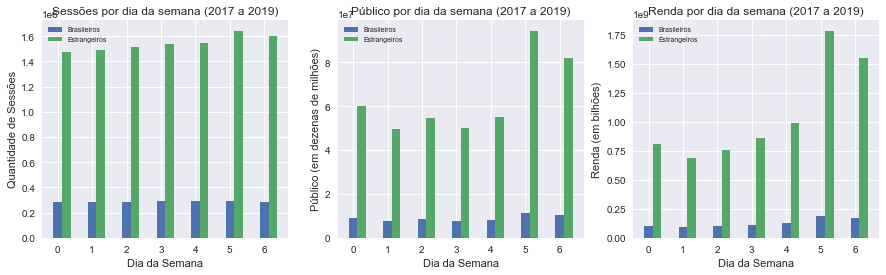

In [22]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4), sharex=True)

ax1.bar(x_index, sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().DATA_SESSAO, label='Brasileiros', width=width)
ax1.bar(x_index + width, sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().DATA_SESSAO, label='Estrangeiros', width=width)

ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_title("Sessões por dia da semana (2017 a 2019)")
ax1.set_xlabel("Dia da Semana")
ax1.set_ylabel("Quantidade de Sessões")
ax1.grid(True)

ax2.bar(x_index, sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().PUBLICO, label='Brasileiros', width=width)
ax2.bar(x_index + width, sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().PUBLICO, label='Estrangeiros', width=width)

ax2.legend(loc='upper left', fontsize='x-small')
ax2.set_title("Público por dia da semana (2017 a 2019)")
ax2.set_xlabel("Dia da Semana")
ax2.set_ylabel("Público (em dezenas de milhões)")
ax2.grid(True)

ax3.bar(x_index, sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Brasileiros', width=width)
ax3.bar(x_index + width, sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Estrangeiros', width=width)

ax3.legend(loc='upper left', fontsize='x-small')
ax3.set_title("Renda por dia da semana (2017 a 2019)")
ax3.set_xlabel("Dia da Semana")
ax3.set_ylabel("Renda (em bilhões)")
ax3.grid(True)

### Barplots: 2017, 2018 and 2019

#### All sessions/movie theaters

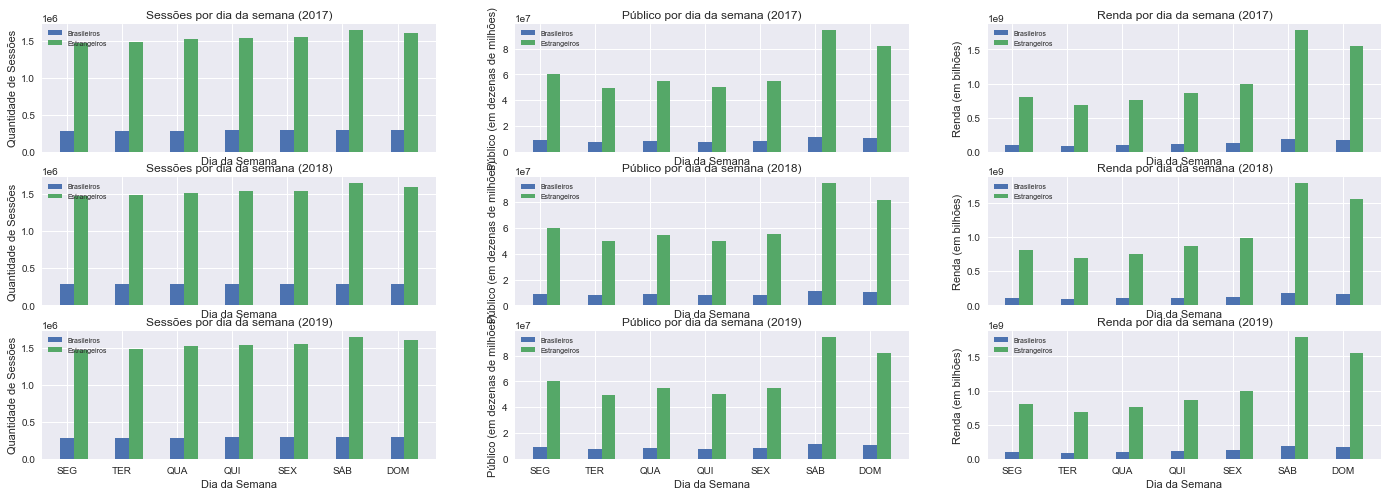

In [27]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,12), sharex=True)


# 2017
ax1.bar(x_index, sessoes_dia_semana_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().DATA_SESSAO, label='Brasileiros', width=width)
ax1.bar(x_index + width, sessoes_dia_semana_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().DATA_SESSAO, label='Estrangeiros', width=width)

ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_title("Sessões por dia da semana (2017)")
ax1.set_xlabel("Dia da Semana")
ax1.set_ylabel("Quantidade de Sessões")
ax1.grid(True)

ax2.bar(x_index, sessoes_dia_semana_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().PUBLICO, label='Brasileiros', width=width)
ax2.bar(x_index + width, sessoes_dia_semana_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().PUBLICO, label='Estrangeiros', width=width)

ax2.legend(loc='upper left', fontsize='x-small')
ax2.set_title("Público por dia da semana (2017)")
ax2.set_xlabel("Dia da Semana")
ax2.set_ylabel("Público (em dezenas de milhões)")
ax2.grid(True)

ax3.bar(x_index, sessoes_dia_semana_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Brasileiros', width=width)
ax3.bar(x_index + width, sessoes_dia_semana_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Estrangeiros', width=width)

ax3.legend(loc='upper left', fontsize='x-small')
ax3.set_title("Renda por dia da semana (2017)")
ax3.set_xlabel("Dia da Semana")
ax3.set_ylabel("Renda (em bilhões)")
ax3.grid(True)

# 2018
ax4.bar(x_index, sessoes_dia_semana_18.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().DATA_SESSAO, label='Brasileiros', width=width)
ax4.bar(x_index + width, sessoes_dia_semana_18.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().DATA_SESSAO, label='Estrangeiros', width=width)

ax4.legend(loc='upper left', fontsize='x-small')
ax4.set_title("Sessões por dia da semana (2018)")
ax4.set_xlabel("Dia da Semana")
ax4.set_ylabel("Quantidade de Sessões")
ax4.grid(True)

ax5.bar(x_index, sessoes_dia_semana_18.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().PUBLICO, label='Brasileiros', width=width)
ax5.bar(x_index + width, sessoes_dia_semana_18.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().PUBLICO, label='Estrangeiros', width=width)

ax5.legend(loc='upper left', fontsize='x-small')
ax5.set_title("Público por dia da semana (2018)")
ax5.set_xlabel("Dia da Semana")
ax5.set_ylabel("Público (em dezenas de milhões)")
ax5.grid(True)

ax6.bar(x_index, sessoes_dia_semana_18.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Brasileiros', width=width)
ax6.bar(x_index + width, sessoes_dia_semana_18.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Estrangeiros', width=width)

ax6.legend(loc='upper left', fontsize='x-small')
ax6.set_title("Renda por dia da semana (2018)")
ax6.set_xlabel("Dia da Semana")
ax6.set_ylabel("Renda (em bilhões)")
ax6.grid(True)

# 2019
ax7.bar(x_index, sessoes_dia_semana_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().DATA_SESSAO, label='Brasileiros', width=width)
ax7.bar(x_index + width, sessoes_dia_semana_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().DATA_SESSAO, label='Estrangeiros', width=width)

ax7.legend(loc='upper left', fontsize='x-small')
ax7.set_title("Sessões por dia da semana (2019)")
ax7.set_xlabel("Dia da Semana")
ax7.set_ylabel("Quantidade de Sessões")
ax7.grid(True)

ax8.bar(x_index, sessoes_dia_semana_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().PUBLICO, label='Brasileiros', width=width)
ax8.bar(x_index + width, sessoes_dia_semana_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().PUBLICO, label='Estrangeiros', width=width)

ax8.legend(loc='upper left', fontsize='x-small')
ax8.set_title("Público por dia da semana (2019)")
ax8.set_xlabel("Dia da Semana")
ax8.set_ylabel("Público (em dezenas de milhões)")
ax8.grid(True)

ax9.bar(x_index, sessoes_dia_semana_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Brasileiros', width=width)
ax9.bar(x_index + width, sessoes_dia_semana_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().RENDA_ATUALIZADA_JAN20, label='Estrangeiros', width=width)

ax9.legend(loc='upper left', fontsize='x-small')
ax9.set_title("Renda por dia da semana (2019)")
ax9.set_xlabel("Dia da Semana")
ax9.set_ylabel("Renda (em bilhões)")
ax9.grid(True)

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

#### Comercial/regular movie theaters and sessions

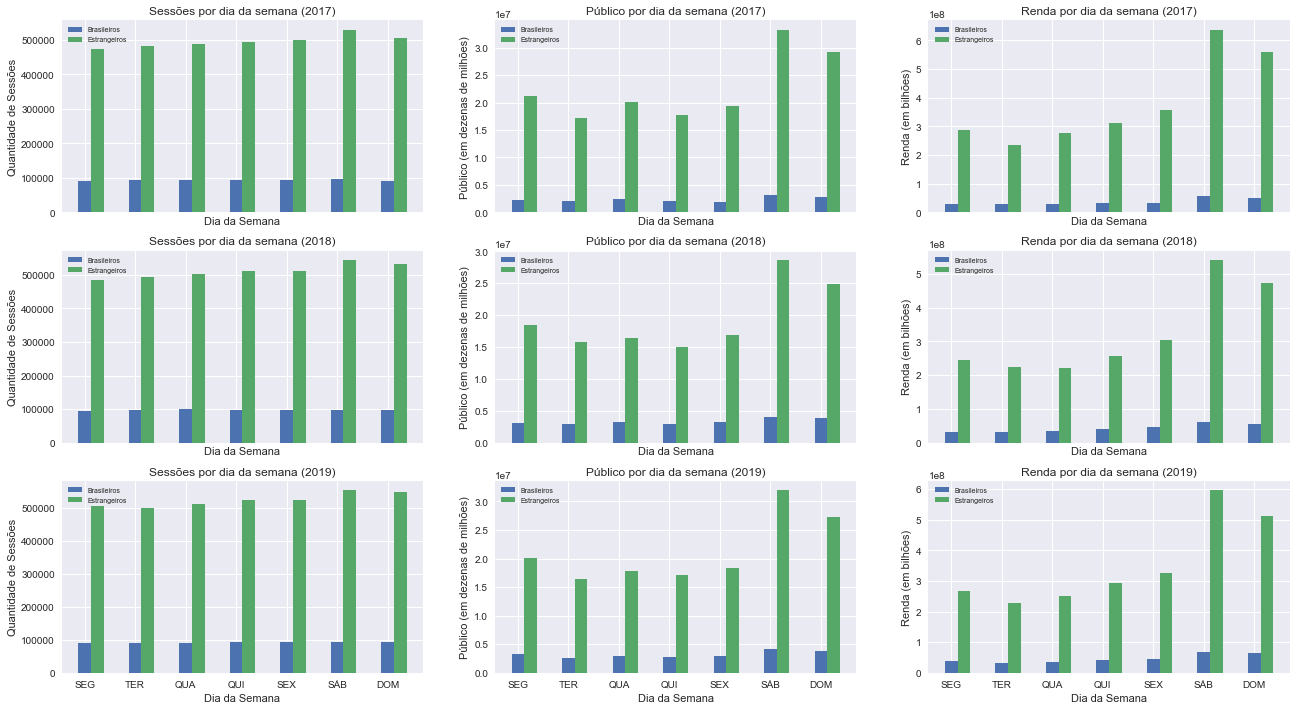

In [26]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(22,12), sharex=True)

raw_br = sessoes_comercial_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est = sessoes_comercial_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()
raw_br_18 = sessoes_comercial_18.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est_18 = sessoes_comercial_18.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()
raw_br_19 = sessoes_comercial_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est_19 = sessoes_comercial_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()

sess_br = raw_br.DATA_SESSAO
sess_est = raw_est.DATA_SESSAO
sess_br_18 = raw_br_18.DATA_SESSAO
sess_est_18 = raw_est_18.DATA_SESSAO
sess_br_19 = raw_br_19.DATA_SESSAO
sess_est_19 = raw_est_19.DATA_SESSAO

pub_br = raw_br.PUBLICO
pub_est = raw_est.PUBLICO
pub_br_18 = raw_br_18.PUBLICO
pub_est_18 = raw_est_18.PUBLICO
pub_br_19 = raw_br_19.PUBLICO
pub_est_19 = raw_est_19.PUBLICO

renda_br = raw_br.RENDA_ATUALIZADA_JAN20
renda_est = raw_est.RENDA_ATUALIZADA_JAN20
renda_br_18 = raw_br_18.RENDA_ATUALIZADA_JAN20
renda_est_18 = raw_est_18.RENDA_ATUALIZADA_JAN20
renda_br_19 = raw_br_19.RENDA_ATUALIZADA_JAN20
renda_est_19 = raw_est_19.RENDA_ATUALIZADA_JAN20

# 2017
ax1.bar(x_index, sess_br, label='Brasileiros', width=width)
ax1.bar(x_index + width, sess_est, label='Estrangeiros', width=width)

ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_title("Sessões por dia da semana (2017)")
ax1.set_xlabel("Dia da Semana")
ax1.set_ylabel("Quantidade de Sessões")
ax1.grid(True)

ax2.bar(x_index, pub_br, label='Brasileiros', width=width)
ax2.bar(x_index + width, pub_est, label='Estrangeiros', width=width)

ax2.legend(loc='upper left', fontsize='x-small')
ax2.set_title("Público por dia da semana (2017)")
ax2.set_xlabel("Dia da Semana")
ax2.set_ylabel("Público (em dezenas de milhões)")
ax2.grid(True)

ax3.bar(x_index, renda_br, label='Brasileiros', width=width)
ax3.bar(x_index + width, renda_est, label='Estrangeiros', width=width)

ax3.legend(loc='upper left', fontsize='x-small')
ax3.set_title("Renda por dia da semana (2017)")
ax3.set_xlabel("Dia da Semana")
ax3.set_ylabel("Renda (em bilhões)")
ax3.grid(True)

# 2018
ax4.bar(x_index, sess_br_18, label='Brasileiros', width=width)
ax4.bar(x_index + width, sess_est_18, label='Estrangeiros', width=width)

ax4.legend(loc='upper left', fontsize='x-small')
ax4.set_title("Sessões por dia da semana (2018)")
ax4.set_xlabel("Dia da Semana")
ax4.set_ylabel("Quantidade de Sessões")
ax4.grid(True)

ax5.bar(x_index, pub_br_18, label='Brasileiros', width=width)
ax5.bar(x_index + width, pub_est_18, label='Estrangeiros', width=width)

ax5.legend(loc='upper left', fontsize='x-small')
ax5.set_title("Público por dia da semana (2018)")
ax5.set_xlabel("Dia da Semana")
ax5.set_ylabel("Público (em dezenas de milhões)")
ax5.grid(True)

ax6.bar(x_index, renda_br_18, label='Brasileiros', width=width)
ax6.bar(x_index + width, renda_est_18, label='Estrangeiros', width=width)

ax6.legend(loc='upper left', fontsize='x-small')
ax6.set_title("Renda por dia da semana (2018)")
ax6.set_xlabel("Dia da Semana")
ax6.set_ylabel("Renda (em bilhões)")
ax6.grid(True)

# 2019
ax7.bar(x_index, sess_br_19, label='Brasileiros', width=width)
ax7.bar(x_index + width, sess_est_19, label='Estrangeiros', width=width)

ax7.legend(loc='upper left', fontsize='x-small')
ax7.set_title("Sessões por dia da semana (2019)")
ax7.set_xlabel("Dia da Semana")
ax7.set_ylabel("Quantidade de Sessões")
ax7.grid(True)

ax8.bar(x_index, pub_br_19, label='Brasileiros', width=width)
ax8.bar(x_index + width, pub_est_19, label='Estrangeiros', width=width)

ax8.legend(loc='upper left', fontsize='x-small')
ax8.set_title("Público por dia da semana (2019)")
ax8.set_xlabel("Dia da Semana")
ax8.set_ylabel("Público (em dezenas de milhões)")
ax8.grid(True)


ax9.bar(x_index, renda_br_19, label='Brasileiros', width=width)
ax9.bar(x_index + width, renda_est_19, label='Estrangeiros', width=width)

ax9.legend(loc='upper left', fontsize='x-small')
ax9.set_title("Renda por dia da semana (2019)")
ax9.set_xlabel("Dia da Semana")
ax9.set_ylabel("Renda (em bilhões)")
ax9.grid(True)

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

#### Ranked by percentile

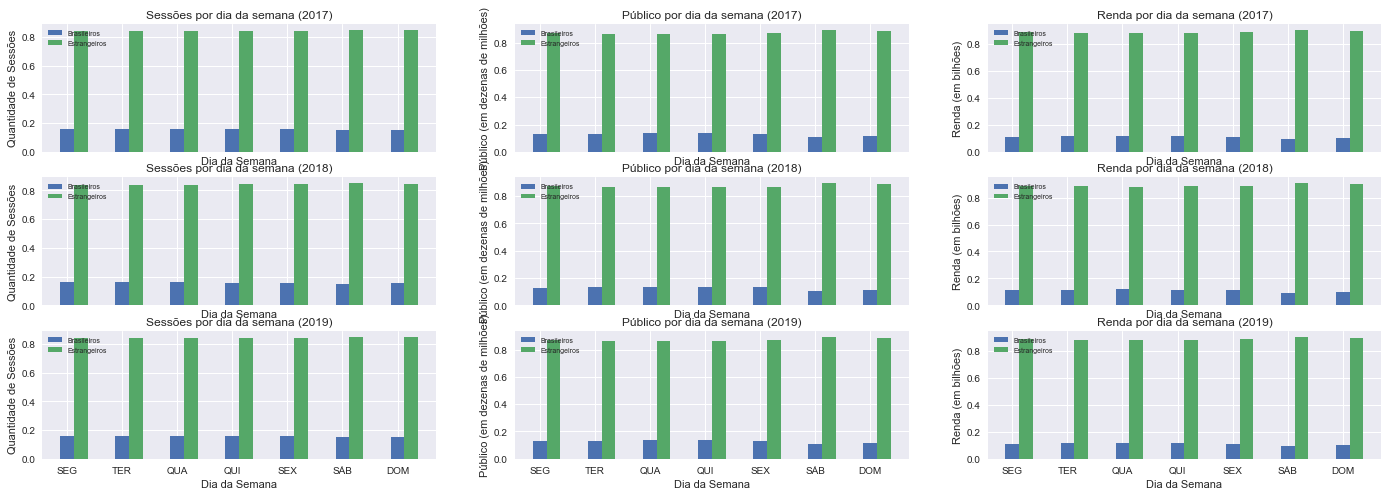

In [14]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

rows = 3
cols = 3

fig, ax = plt.subplots(rows,cols,figsize=(24,8), sharex=True)

data = [sessoes_dia_semana_17, sessoes_dia_semana_18, sessoes_dia_semana_19]

attrib = ['DATA_SESSAO_NORMALIZADO', 'PUBLICO_NORMALIZADO', 'RENDA_ATUALIZADA_JAN20_NORMALIZADO']

tit_labels = ['Sessões', 'Público', 'Renda']

y_labels = ["Quantidade de Sessões","Público (em dezenas de milhões)","Renda (em bilhões)"]

norm_labels = [y+'[Normalizado]' for y in y_labels]

for row in range(rows):
    for col in range(cols):
        ax[row][col].(x_index, data[row].query("NACIONALIDADE == 'BRASILEIRA'"
                                              ).reset_index()[attrib[col]], label='Brasileiros', width=width)
        ax[row][col].(x_index + width, data[row].query("NACIONALIDADE == 'ESTRANGEIRA'"
                                              ).reset_index()[attrib[col]], label='Brasileiros', width=width)
        # settings
        ax[row][col].legend(loc='upper left', fontsize='x-small')
        ax[row][col].set_title(f"{tit_labels[col]} por dia da semana (2017)")
        ax[row][col].set_xlabel("Dia da Semana")
        ax[row][col].set_ylabel(norm_labels[col])
        ax[row][col].grid(True)
        

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

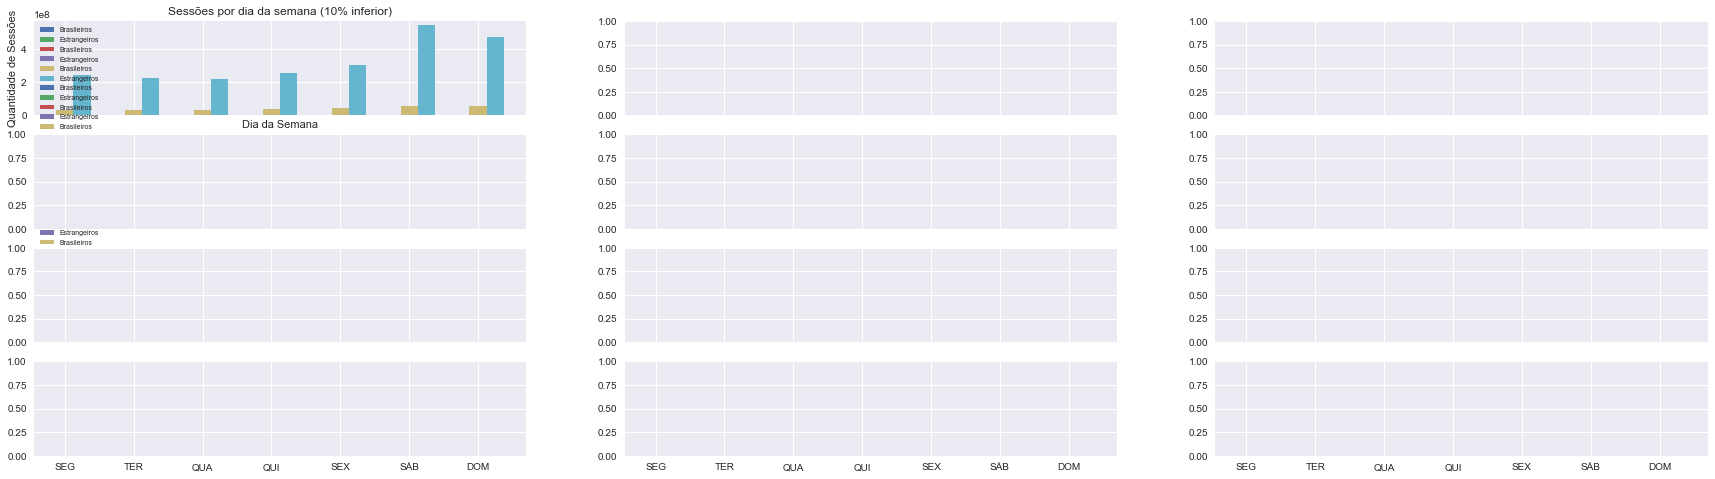

In [27]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

filt_br = "NACIONALIDADE == 'BRASILEIRA' & ANO_CINEMATOGRAFICO == @y"
filt_est = "NACIONALIDADE == 'ESTRANGEIRA' & ANO_CINEMATOGRAFICO == @y"

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4,3,figsize=(30,8), sharex=True)

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]

count = 0

ylabels = ['Quantidade de Sessões','Público (em dezenas de milhões)','Renda (em bilhões)']
titles = ['Sessões','Público','Renda']

for y in [2017,2018]:
    for data in [sessoes_upper,sessoes_lower]:
        data_br = sessoes_upper.query(filt_br).reset_index()
        data_est = sessoes_upper.query(filt_est).reset_index()
        for col in ['DATA_SESSAO','PUBLICO','RENDA_ATUALIZADA_JAN20']:
            col_br = data_br[col]
            col_est = data_est[col]
            
            ax_list[count].bar(x_index, col_br, label='Brasileiros', width=width)
            ax_list[count].bar(x_index + width, col_est, label='Estrangeiros', width=width)
            
            # axis settings
            ax_list[count].legend(loc='upper left', fontsize='x-small')
            ax_list[count].set_xlabel("Dia da Semana")
            ax_list[count].set_ylabel(ylabels[(count % 3)])
            ax_list[count].grid(True)
            tit = titles[(count % 3)]
            if data is sessoes_upper:
                ax_list[count].set_title(f"{tit} por dia da semana (10% superior)")
            else:
                ax_list[count].set_title(f"{tit} por dia da semana (10% inferior)")
            
plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

### Barplots: 2017, 2018 and 2019 (normalized)

In [60]:
# getting total to normalize

s_dict = {'DATA_SESSAO':'sum','PUBLICO':'sum','RENDA_ATUALIZADA_JAN20':'sum'}

# sessoes_dia_semana_17 was defined below 3.2

sums = sessoes_dia_semana_17.groupby('DIA_SEMANA').agg(s_dict)

# sessoes_dia_semana_18 was defined below 3.2

sums_18 = sessoes_dia_semana_18.groupby('DIA_SEMANA').agg(s_dict)

# sessoes_dia_semana_19 was defined below 3.2
sums_19 = sessoes_dia_semana_19.groupby('DIA_SEMANA').agg(s_dict)

cols = ['DATA_SESSAO', 'PUBLICO', 'RENDA_ATUALIZADA_JAN20'] # cols to be normalized

# loop to include totals per line

for i, r in sessoes_dia_semana_17.iterrows():
    dia = r['DIA_SEMANA']
    for c in cols:
        sessoes_dia_semana_17.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums.loc[dia,c]

for i, r in sessoes_dia_semana_18.iterrows():
    dia = r['DIA_SEMANA']
    for c in cols:
        sessoes_dia_semana_18.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_18.loc[dia,c]        
        
for i, r in sessoes_dia_semana_19.iterrows():
    dia = r['DIA_SEMANA']
    for c in cols:
        sessoes_dia_semana_19.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_19.loc[dia,c]

In [61]:
# getting total to normalize

# sessoes_comercial_17 was defined below 3.2
sums_comercial_17 = sessoes_comercial_17.groupby('DIA_SEMANA').agg(s_dict)

# sessoes_comercial_18 was defined below 3.2
sums_comercial_18 = sessoes_comercial_18.groupby('DIA_SEMANA').agg(s_dict)

# sessoes_comercial_19 was defined below 3.2
sums_comercial_19 = sessoes_comercial_19.groupby('DIA_SEMANA').agg(s_dict)

cols = ['DATA_SESSAO', 'PUBLICO', 'RENDA_ATUALIZADA_JAN20'] # cols to be normalized

# loop to include totals per line

for i, r in sessoes_comercial_17.iterrows():
    dia = r['DIA_SEMANA']
    for c in cols:
        sessoes_comercial_17.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_comercial_17.loc[dia,c]

for i, r in sessoes_comercial_18.iterrows():
    dia = r['DIA_SEMANA']
    for c in cols:
        sessoes_comercial_18.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_comercial_18.loc[dia,c]
        
for i, r in sessoes_comercial_19.iterrows():
    dia = r['DIA_SEMANA']
    for c in cols:
        sessoes_comercial_19.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_comercial_19.loc[dia,c]

In [62]:
# getting total to normalize

# sessoes_upper was defined below 3.2

gp = ['ANO_CINEMATOGRAFICO','DIA_SEMANA']

sums_upper = sessoes_upper.groupby(gp).agg(s_dict)

# sessoes_lower was defined below 3.2
sums_lower = sessoes_lower.groupby(gp).agg(s_dict)

cols = ['DATA_SESSAO', 'PUBLICO', 'RENDA_ATUALIZADA_JAN20'] # cols to be normalized

# loop to include totals per line

for i, r in sessoes_upper.iterrows():
    dia = r['DIA_SEMANA']
    ano = r['ANO_CINEMATOGRAFICO']
    for c in cols:
        sessoes_upper.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_upper.loc[(ano,dia),c]

for i, r in sessoes_lower.iterrows():
    dia = r['DIA_SEMANA']
    ano = r['ANO_CINEMATOGRAFICO']
    for c in cols:
        sessoes_lower.loc[i,f'{c}_NORMALIZADO'] = r[c] / sums_lower.loc[(ano,dia),c]
        
del gp

#### All sessions/movie theaters (use as template)

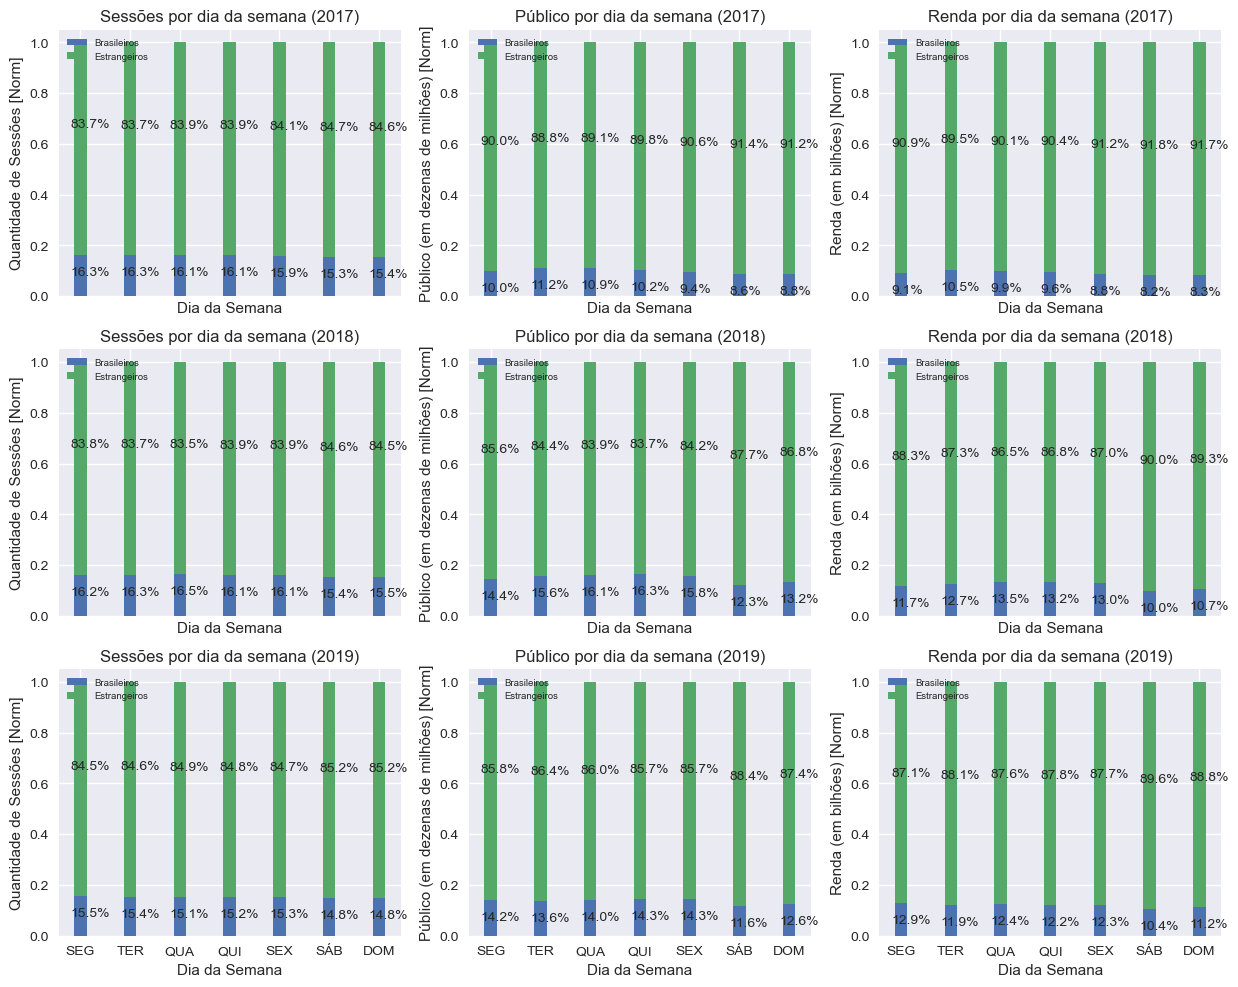

In [69]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

rows = 3 # if rows = 1, have to remove subscript from ax object, ax[col] and not ax[row][col]
cols = 3

fig, ax = plt.subplots(rows,cols,figsize=(15,12), dpi=100, sharex=True)

data = [sessoes_dia_semana_17, sessoes_dia_semana_18, sessoes_dia_semana_19]

attrib = ['DATA_SESSAO_NORMALIZADO', 'PUBLICO_NORMALIZADO', 'RENDA_ATUALIZADA_JAN20_NORMALIZADO']

idx = 0

tit_labels = ['Sessões', 'Público', 'Renda']

y_labels = ["Quantidade de Sessões","Público (em dezenas de milhões)","Renda (em bilhões)"]

norm_labels = [y+r' [Norm]' for y in y_labels]


for row in range(rows):
    for col in range(cols):
        bottom = data[row].query("NACIONALIDADE == 'BRASILEIRA'").reset_index()[attrib[col]]
        top = data[row].query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()[attrib[col]]
        ax[row][col].bar(x_index, bottom, label='Brasileiros', width=width)
        ax[row][col].bar(x_index, top, label='Estrangeiros', width=width, bottom=bottom)
        
        # percentage text comment
        for i in range(7):
            ax[row][col].text(i-0.2,(bottom[i] - 0.08), f'{np.round(bottom[i]*100,1)}%')
            ax[row][col].text(i-0.2,(bottom[i] + 0.5), f'{np.round(top[i]*100,1)}%')
        
        # settings
        ax[row][col].legend(loc='upper left', fontsize='x-small')
        ax[row][col].set_title(f"{tit_labels[col]} por dia da semana ({2017+row})")
        ax[row][col].set_xlabel("Dia da Semana")
        ax[row][col].set_ylabel(norm_labels[col])
        ax[row][col].grid(True)
        

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

#### Comercial/regular movie theaters and sessions

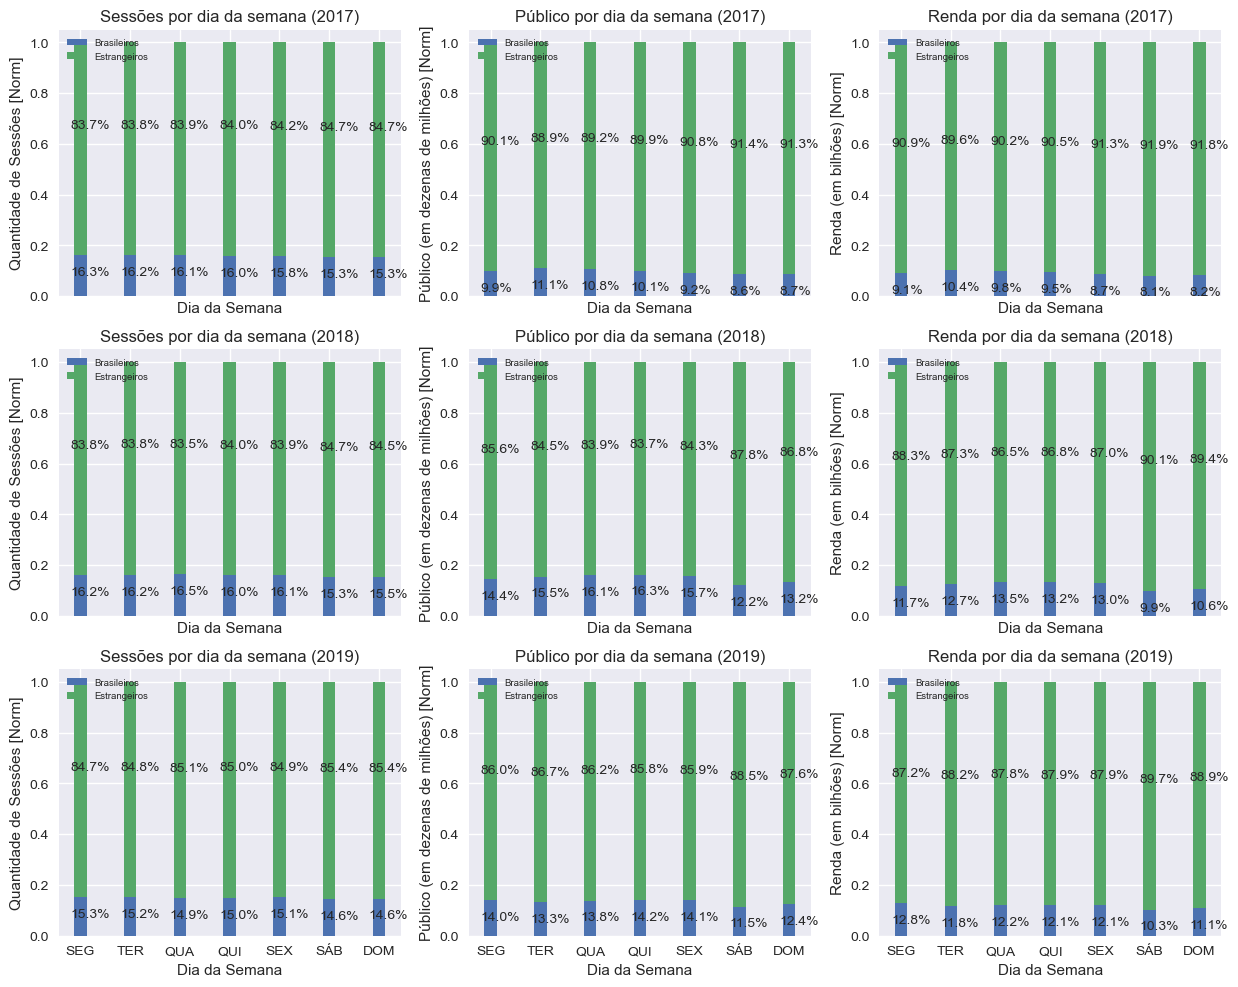

In [71]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

rows = 3 # if rows = 1, have to remove subscript from ax object, ax[col] and not ax[row][col]
ccols = 3

fig, ax = plt.subplots(rows,cols,figsize=(15,12), dpi=100, sharex=True)

data = [sessoes_comercial_17, sessoes_comercial_18, sessoes_comercial_19]

attrib = ['DATA_SESSAO_NORMALIZADO', 'PUBLICO_NORMALIZADO', 'RENDA_ATUALIZADA_JAN20_NORMALIZADO']

idx = 0 # just for one-row graphs

tit_labels = ['Sessões', 'Público', 'Renda']

y_labels = ["Quantidade de Sessões","Público (em dezenas de milhões)","Renda (em bilhões)"]

norm_labels = [y+r' [Norm]' for y in y_labels]


for row in range(rows):
    for col in range(cols):
        bottom = data[row].query("NACIONALIDADE == 'BRASILEIRA'").reset_index()[attrib[col]]
        top = data[row].query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()[attrib[col]]
        ax[row][col].bar(x_index, bottom, label='Brasileiros', width=width)
        ax[row][col].bar(x_index, top, label='Estrangeiros', width=width, bottom=bottom)
        
        # percentage text comment
        for i in range(7):
            ax[row][col].text(i-0.2,(bottom[i] - 0.08), f'{np.round(bottom[i]*100,1)}%')
            ax[row][col].text(i-0.2,(bottom[i] + 0.5), f'{np.round(top[i]*100,1)}%')
        
        # settings
        ax[row][col].legend(loc='upper left', fontsize='x-small')
        ax[row][col].set_title(f"{tit_labels[col]} por dia da semana ({2017+row})")
        ax[row][col].set_xlabel("Dia da Semana")
        ax[row][col].set_ylabel(norm_labels[col])
        ax[row][col].grid(True)
        

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

#### Ranked by percentile

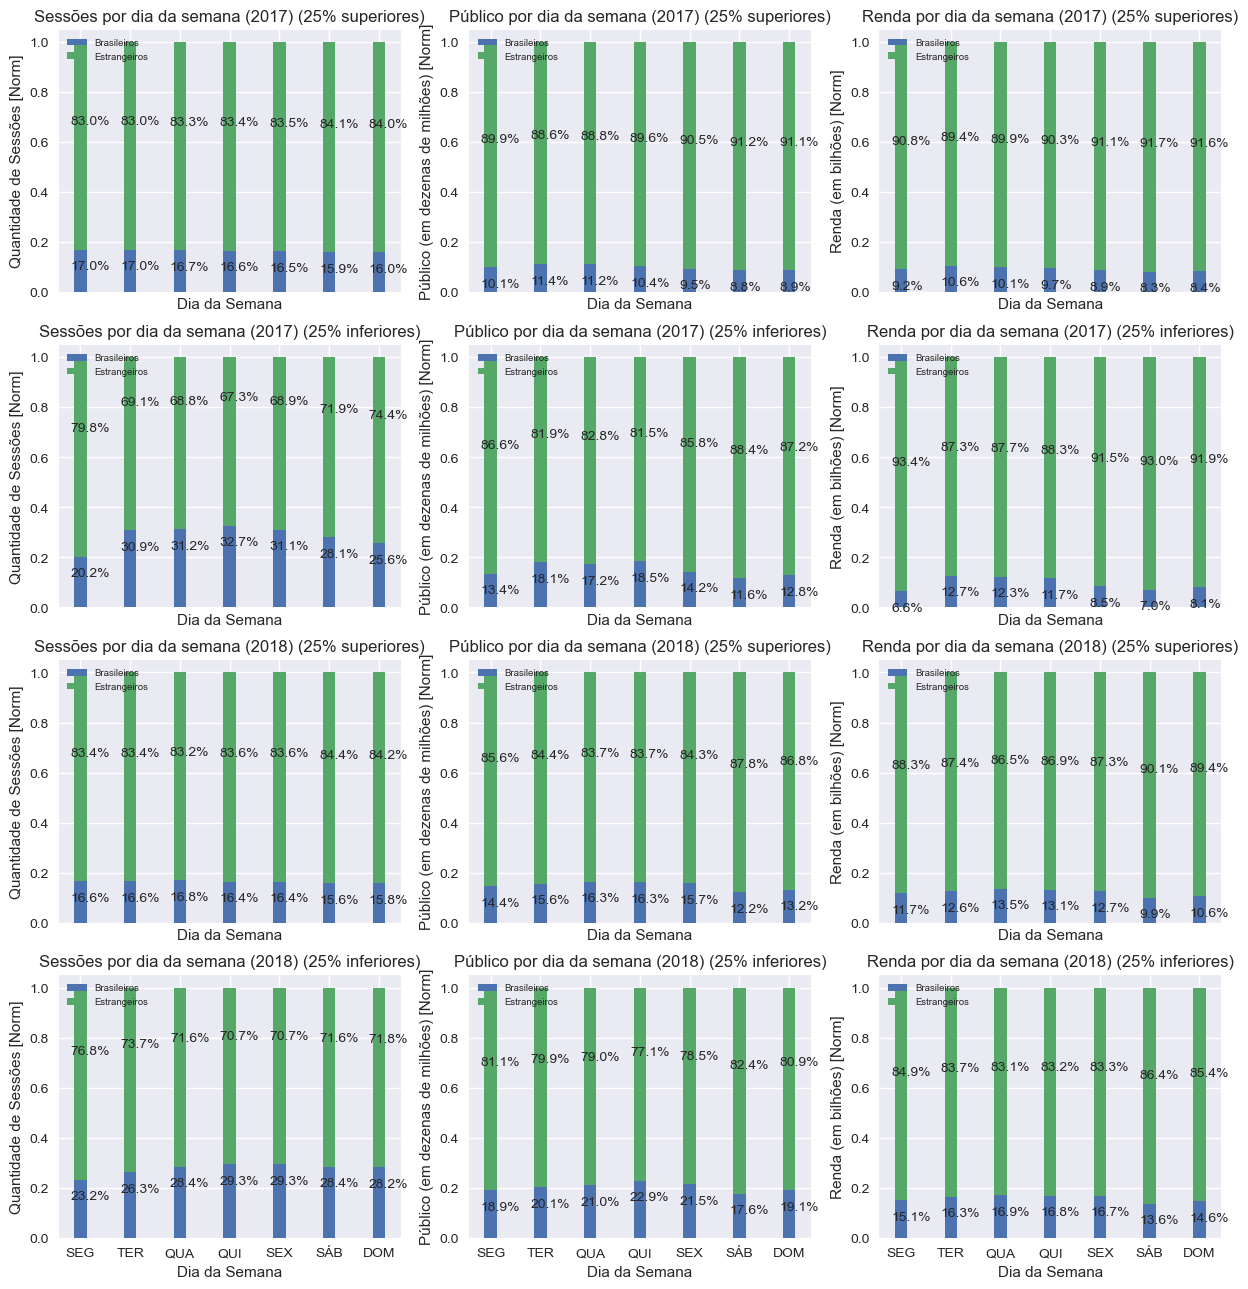

In [65]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

rows = 4 # if rows = 1, have to remove subscript from ax object, ax[col] and not ax[row][col]
cols = 3

fig, ax = plt.subplots(rows,cols,figsize=(15,(4*rows)), dpi=100, sharex=True)

data = [sessoes_upper, sessoes_lower, sessoes_upper, sessoes_lower]

attrib = ['DATA_SESSAO_NORMALIZADO', 'PUBLICO_NORMALIZADO', 'RENDA_ATUALIZADA_JAN20_NORMALIZADO']

idx = 0

up_low = [f'({int((1-ut)*100)}% superiores)', f'({int(lt*100)}% inferiores)'] # ut, lt defined in 3.2.1

tit_labels = ['Sessões', 'Público', 'Renda']

y_labels = ["Quantidade de Sessões", "Público (em dezenas de milhões)", "Renda (em bilhões)"]

norm_labels = [y+r' [Norm]' for y in y_labels]


for row in range(rows):
    for col in range(cols):
        y = 2017 + (row // 2)
        bottom = data[row].query("NACIONALIDADE == 'BRASILEIRA' & ANO_CINEMATOGRAFICO == @y").reset_index()[attrib[col]]
        top = data[row].query("NACIONALIDADE == 'ESTRANGEIRA' & ANO_CINEMATOGRAFICO == @y").reset_index()[attrib[col]]
        ax[row][col].bar(x_index, bottom, label='Brasileiros', width=width)
        ax[row][col].bar(x_index, top, label='Estrangeiros', width=width, bottom=bottom)
        
        # percentage text comment
        for i in range(7):
            ax[row][col].text(i-0.2,(bottom[i] - 0.08), f'{np.round(bottom[i]*100,1)}%')
            ax[row][col].text(i-0.2,(bottom[i] + 0.5), f'{np.round(top[i]*100,1)}%')
        
        # settings
        ax[row][col].legend(loc='upper left', fontsize='x-small')
        t_count = row % 2
        ax[row][col].set_title(f"{tit_labels[col]} por dia da semana ({2017+(row//2)}) {up_low[t_count]}")
        ax[row][col].set_xlabel("Dia da Semana")
        ax[row][col].set_ylabel(norm_labels[col])
        ax[row][col].grid(True)
        

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

### Barplots: 2017-2018 and 2019 (normalized)

#### All sessions/movietheaters

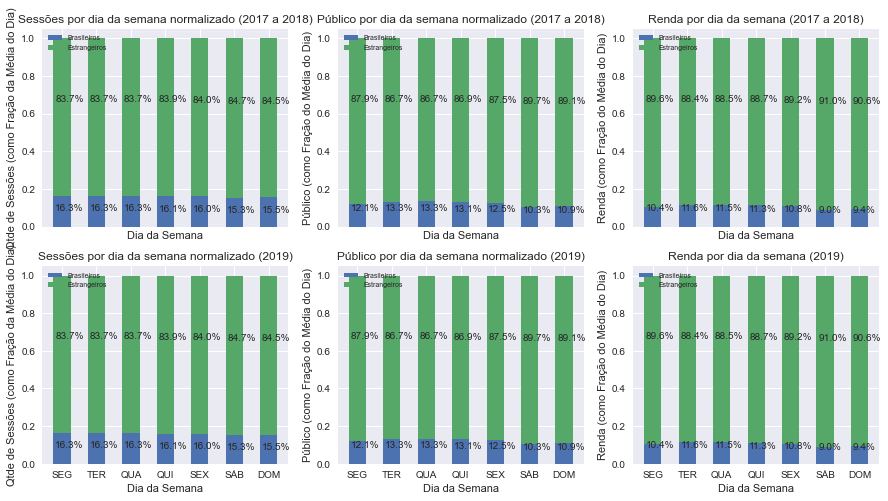

In [106]:
%matplotlib inline

x_index = np.arange(7)

width = 0.5

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,8), sharex=True)

sess_br = sessoes_dia_semana_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().DATA_SESSAO_NORMALIZADO
sess_est = sessoes_dia_semana_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().DATA_SESSAO_NORMALIZADO

ax1.bar(x_index, 
        sess_br, label='Brasileiros', width=width)
ax1.bar(x_index, sess_est,
        label='Estrangeiros', width=width, bottom=sess_br)

ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_title("Sessões por dia da semana normalizado (2017 a 2018)")
ax1.set_xlabel("Dia da Semana")
ax1.set_ylabel("Qtde de Sessões (como Fração da Média do Dia)")
ax1.grid(True)

pub_br = sessoes_dia_semana_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().PUBLICO_NORMALIZADO
pub_est = sessoes_dia_semana_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().PUBLICO_NORMALIZADO

ax2.bar(x_index, pub_br, label='Brasileiros', width=width)
ax2.bar(x_index, pub_est, label='Estrangeiros', width=width, bottom=pub_br)

ax2.legend(loc='upper left', fontsize='x-small')
ax2.set_title("Público por dia da semana normalizado (2017 a 2018)")
ax2.set_xlabel("Dia da Semana")
ax2.set_ylabel("Público (como Fração do Média do Dia)")
ax2.grid(True)

renda_br = sessoes_dia_semana_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_est = sessoes_dia_semana_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().RENDA_ATUALIZADA_JAN20_NORMALIZADO

ax3.bar(x_index, renda_br, label='Brasileiros', width=width)
ax3.bar(x_index, renda_est, label='Estrangeiros', width=width, bottom=renda_br)

ax3.legend(loc='upper left', fontsize='x-small')
ax3.set_title("Renda por dia da semana (2017 a 2018)")
ax3.set_xlabel("Dia da Semana")
ax3.set_ylabel("Renda (como Fração do Média do Dia)")
ax3.grid(True)


sess_br_19 = sessoes_dia_semana_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().DATA_SESSAO_NORMALIZADO
sess_est_19 = sessoes_dia_semana_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().DATA_SESSAO_NORMALIZADO

ax4.bar(x_index, 
        sess_br_19, label='Brasileiros', width=width)
ax4.bar(x_index, sess_est_19, label='Estrangeiros', width=width, bottom=sess_br_19)

ax4.legend(loc='upper left', fontsize='x-small')
ax4.set_title("Sessões por dia da semana normalizado (2019)")
ax4.set_xlabel("Dia da Semana")
ax4.set_ylabel("Qtde de Sessões (como Fração da Média do Dia)")
ax4.grid(True)

pub_br_19 = sessoes_dia_semana_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().PUBLICO_NORMALIZADO
pub_est_19 = sessoes_dia_semana_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().PUBLICO_NORMALIZADO

ax5.bar(x_index, pub_br_19, label='Brasileiros', width=width)
ax5.bar(x_index, pub_est_19, label='Estrangeiros', width=width, bottom=pub_br_19)

ax5.legend(loc='upper left', fontsize='x-small')
ax5.set_title("Público por dia da semana normalizado (2019)")
ax5.set_xlabel("Dia da Semana")
ax5.set_ylabel("Público (como Fração do Média do Dia)")
ax5.grid(True)

renda_br_19 = sessoes_dia_semana_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index().RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_est_19 = sessoes_dia_semana_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index().RENDA_ATUALIZADA_JAN20_NORMALIZADO

ax6.bar(x_index, renda_br_19, label='Brasileiros', width=width)
ax6.bar(x_index, renda_est_19, label='Estrangeiros', width=width, bottom=renda_br_19)

ax6.legend(loc='upper left', fontsize='x-small')
ax6.set_title("Renda por dia da semana (2019)")
ax6.set_xlabel("Dia da Semana")
ax6.set_ylabel("Renda (como Fração do Média do Dia)")
ax6.grid(True)

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])


for i in range(7):
    ax1.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(sess_br[i]*100,1)}%')
    ax1.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(sess_est[i]*100,1)}%')
    ax2.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(pub_br[i]*100,1)}%')
    ax2.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(pub_est[i]*100,1)}%')
    ax3.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(renda_br[i]*100,1)}%')
    ax3.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(renda_est[i]*100,1)}%')
    ax4.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(sess_br_19[i]*100,1)}%')
    ax4.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(sess_est_19[i]*100,1)}%')
    ax5.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(pub_br_19[i]*100,1)}%')
    ax5.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(pub_est_19[i]*100,1)}%')
    ax6.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(renda_br_19[i]*100,1)}%')
    ax6.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(renda_est_19[i]*100,1)}%')

#### Comercial/regular movie theaters and sessions

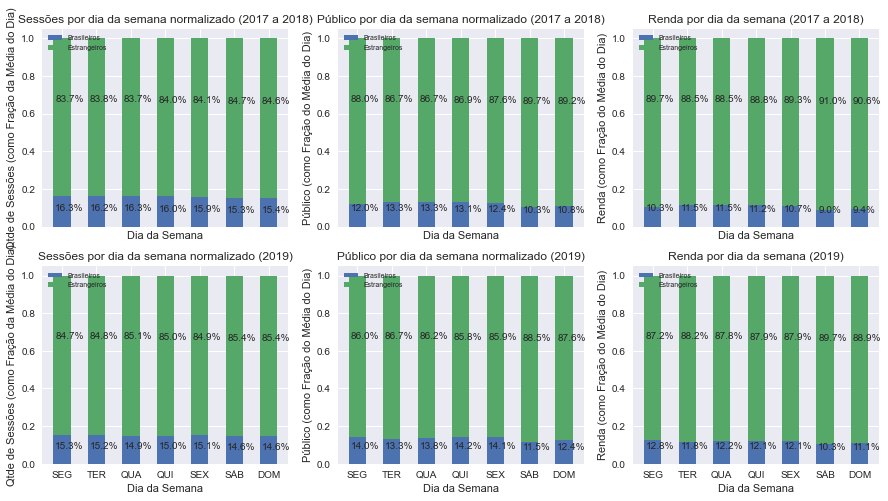

In [107]:
%matplotlib inline

x_index = np.arange(7)

width = 0.5

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,8), sharex=True)

raw_br = sessoes_comercial_17.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est = sessoes_comercial_17.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()
raw_br_19 = sessoes_comercial_19.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est_19 = sessoes_comercial_19.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()

sess_br = raw_br.DATA_SESSAO_NORMALIZADO
sess_est = raw_est.DATA_SESSAO_NORMALIZADO
sess_br_19 = raw_br_19.DATA_SESSAO_NORMALIZADO
sess_est_19 = raw_est_19.DATA_SESSAO_NORMALIZADO

pub_br = raw_br.PUBLICO_NORMALIZADO
pub_est = raw_est.PUBLICO_NORMALIZADO
pub_br_19 = raw_br_19.PUBLICO_NORMALIZADO
pub_est_19 = raw_est_19.PUBLICO_NORMALIZADO

renda_br = raw_br.RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_est = raw_est.RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_br_19 = raw_br_19.RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_est_19 = raw_est_19.RENDA_ATUALIZADA_JAN20_NORMALIZADO

ax1.bar(x_index, 
        sess_br, label='Brasileiros', width=width)
ax1.bar(x_index, sess_est,
        label='Estrangeiros', width=width, bottom=sess_br)

ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_title("Sessões por dia da semana normalizado (2017 a 2018)")
ax1.set_xlabel("Dia da Semana")
ax1.set_ylabel("Qtde de Sessões (como Fração da Média do Dia)")
ax1.grid(True)

ax2.bar(x_index, pub_br, label='Brasileiros', width=width)
ax2.bar(x_index, pub_est, label='Estrangeiros', width=width, bottom=pub_br)

ax2.legend(loc='upper left', fontsize='x-small')
ax2.set_title("Público por dia da semana normalizado (2017 a 2018)")
ax2.set_xlabel("Dia da Semana")
ax2.set_ylabel("Público (como Fração do Média do Dia)")
ax2.grid(True)

ax3.bar(x_index, renda_br, label='Brasileiros', width=width)
ax3.bar(x_index, renda_est, label='Estrangeiros', width=width, bottom=renda_br)

ax3.legend(loc='upper left', fontsize='x-small')
ax3.set_title("Renda por dia da semana (2017 a 2018)")
ax3.set_xlabel("Dia da Semana")
ax3.set_ylabel("Renda (como Fração do Média do Dia)")
ax3.grid(True)

ax4.bar(x_index, 
        sess_br_19, label='Brasileiros', width=width)
ax4.bar(x_index, sess_est_19, label='Estrangeiros', width=width, bottom=sess_br_19)

ax4.legend(loc='upper left', fontsize='x-small')
ax4.set_title("Sessões por dia da semana normalizado (2019)")
ax4.set_xlabel("Dia da Semana")
ax4.set_ylabel("Qtde de Sessões (como Fração da Média do Dia)")
ax4.grid(True)

ax5.bar(x_index, pub_br_19, label='Brasileiros', width=width)
ax5.bar(x_index, pub_est_19, label='Estrangeiros', width=width, bottom=pub_br_19)

ax5.legend(loc='upper left', fontsize='x-small')
ax5.set_title("Público por dia da semana normalizado (2019)")
ax5.set_xlabel("Dia da Semana")
ax5.set_ylabel("Público (como Fração do Média do Dia)")
ax5.grid(True)

ax6.bar(x_index, renda_br_19, label='Brasileiros', width=width)
ax6.bar(x_index, renda_est_19, label='Estrangeiros', width=width, bottom=renda_br_19)

ax6.legend(loc='upper left', fontsize='x-small')
ax6.set_title("Renda por dia da semana (2019)")
ax6.set_xlabel("Dia da Semana")
ax6.set_ylabel("Renda (como Fração do Média do Dia)")
ax6.grid(True)

plt.xticks(x_index, [d[:3] for d in sessoes_comercial_17.DIA_SEMANA.unique()])


for i in range(7):
    ax1.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(sess_br[i]*100,1)}%')
    ax1.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(sess_est[i]*100,1)}%')
    ax2.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(pub_br[i]*100,1)}%')
    ax2.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(pub_est[i]*100,1)}%')
    ax3.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(renda_br[i]*100,1)}%')
    ax3.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(renda_est[i]*100,1)}%')
    ax4.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(sess_br_19[i]*100,1)}%')
    ax4.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(sess_est_19[i]*100,1)}%')
    ax5.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(pub_br_19[i]*100,1)}%')
    ax5.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(pub_est_19[i]*100,1)}%')
    ax6.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(renda_br_19[i]*100,1)}%')
    ax6.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(renda_est_19[i]*100,1)}%')

#### Ranked by percentile

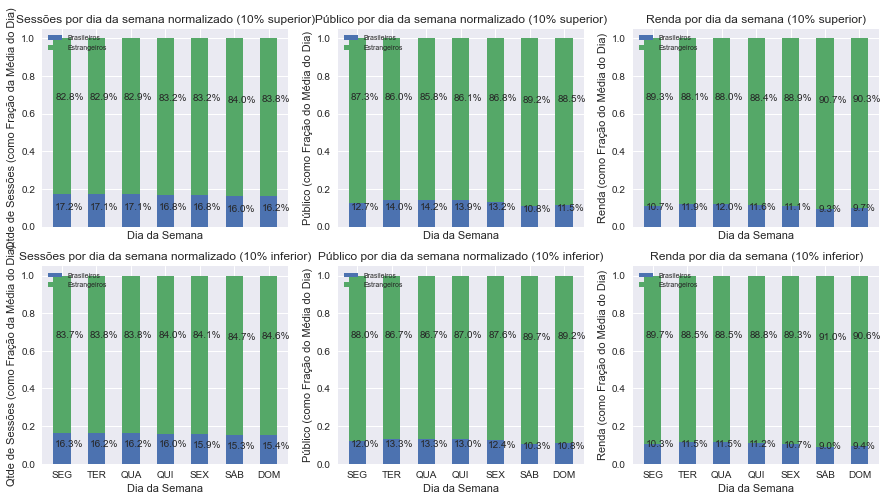

In [108]:
x_index = np.arange(7)

width = 0.5

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,8), sharex=True)

raw_br = sessoes_upper.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est = sessoes_upper.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()
raw_br_19 = sessoes_lower.query("NACIONALIDADE == 'BRASILEIRA'").reset_index()
raw_est_19 = sessoes_lower.query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()

sess_br = raw_br.DATA_SESSAO_NORMALIZADO
sess_est = raw_est.DATA_SESSAO_NORMALIZADO
sess_br_19 = raw_br_19.DATA_SESSAO_NORMALIZADO
sess_est_19 = raw_est_19.DATA_SESSAO_NORMALIZADO

pub_br = raw_br.PUBLICO_NORMALIZADO
pub_est = raw_est.PUBLICO_NORMALIZADO
pub_br_19 = raw_br_19.PUBLICO_NORMALIZADO
pub_est_19 = raw_est_19.PUBLICO_NORMALIZADO

renda_br = raw_br.RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_est = raw_est.RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_br_19 = raw_br_19.RENDA_ATUALIZADA_JAN20_NORMALIZADO
renda_est_19 = raw_est_19.RENDA_ATUALIZADA_JAN20_NORMALIZADO

ax1.bar(x_index, 
        sess_br, label='Brasileiros', width=width)
ax1.bar(x_index, sess_est,
        label='Estrangeiros', width=width, bottom=sess_br)

ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_title("Sessões por dia da semana normalizado (10% superior)")
ax1.set_xlabel("Dia da Semana")
ax1.set_ylabel("Qtde de Sessões (como Fração da Média do Dia)")
ax1.grid(True)

ax2.bar(x_index, pub_br, label='Brasileiros', width=width)
ax2.bar(x_index, pub_est, label='Estrangeiros', width=width, bottom=pub_br)

ax2.legend(loc='upper left', fontsize='x-small')
ax2.set_title("Público por dia da semana normalizado (10% superior)")
ax2.set_xlabel("Dia da Semana")
ax2.set_ylabel("Público (como Fração do Média do Dia)")
ax2.grid(True)

ax3.bar(x_index, renda_br, label='Brasileiros', width=width)
ax3.bar(x_index, renda_est, label='Estrangeiros', width=width, bottom=renda_br)

ax3.legend(loc='upper left', fontsize='x-small')
ax3.set_title("Renda por dia da semana (10% superior)")
ax3.set_xlabel("Dia da Semana")
ax3.set_ylabel("Renda (como Fração do Média do Dia)")
ax3.grid(True)



ax4.bar(x_index, 
        sess_br_19, label='Brasileiros', width=width)
ax4.bar(x_index, sess_est_19, label='Estrangeiros', width=width, bottom=sess_br_19)

ax4.legend(loc='upper left', fontsize='x-small')
ax4.set_title("Sessões por dia da semana normalizado (10% inferior)")
ax4.set_xlabel("Dia da Semana")
ax4.set_ylabel("Qtde de Sessões (como Fração da Média do Dia)")
ax4.grid(True)

ax5.bar(x_index, pub_br_19, label='Brasileiros', width=width)
ax5.bar(x_index, pub_est_19, label='Estrangeiros', width=width, bottom=pub_br_19)

ax5.legend(loc='upper left', fontsize='x-small')
ax5.set_title("Público por dia da semana normalizado (10% inferior)")
ax5.set_xlabel("Dia da Semana")
ax5.set_ylabel("Público (como Fração do Média do Dia)")
ax5.grid(True)

ax6.bar(x_index, renda_br_19, label='Brasileiros', width=width)
ax6.bar(x_index, renda_est_19, label='Estrangeiros', width=width, bottom=renda_br_19)

ax6.legend(loc='upper left', fontsize='x-small')
ax6.set_title("Renda por dia da semana (10% inferior)")
ax6.set_xlabel("Dia da Semana")
ax6.set_ylabel("Renda (como Fração do Média do Dia)")
ax6.grid(True)

plt.xticks(x_index, [d[:3] for d in sessoes_upper.DIA_SEMANA.unique()])


for i in range(7):
    ax1.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(sess_br[i]*100,1)}%')
    ax1.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(sess_est[i]*100,1)}%')
    ax2.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(pub_br[i]*100,1)}%')
    ax2.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(pub_est[i]*100,1)}%')
    ax3.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(renda_br[i]*100,1)}%')
    ax3.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(renda_est[i]*100,1)}%')
    ax4.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(sess_br_19[i]*100,1)}%')
    ax4.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(sess_est_19[i]*100,1)}%')
    ax5.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(pub_br_19[i]*100,1)}%')
    ax5.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(pub_est_19[i]*100,1)}%')
    ax6.text(i-0.2,(sess_br[i] - 0.08), f'{np.round(renda_br_19[i]*100,1)}%')
    ax6.text(i-0.2,(sess_br[i] + 0.5), f'{np.round(renda_est_19[i]*100,1)}%')

### Correlations: sessions per day vs. percentage of BR movies

In [5]:
# getting only date out datetime info to use as groupby parameter
scb_trab['DATA'] = scb_trab.DATA_HORA_SESSAO.apply(lambda x: x.date()) 

In [6]:
# filter only comercial regular sessions
base_filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR'"
filt = "COMERCIAL == 'COMERCIAL' & TIPO_SESSAO == 'SESSÃO REGULAR' & ANO_CINEMATOGRAFICO "


# function to get fraction of BR movie sessions out of total sessions of a given day in a VR
def reckon(series):
    return (np.sum(series == 'BRASILEIRA') / len(series))

# agg dict
corr_dict = {
    'REGISTRO_COMPLEXO':'first', 'REGISTRO_GRUPO':'first', 'NACIONALIDADE':[reckon],
    'DATA_SESSAO':'count', 'ANO_CINEMATOGRAFICO':'first'
}

# groupings

corr = scb_trab.query(base_filt).groupby(
    ['REGISTRO_SALA','DATA'], as_index=False).agg(corr_dict)

# corr_17 = scb_trab.query(filt+'!= 2019').groupby(
#     ['REGISTRO_SALA','DATA'], as_index=False).agg(corr_dict)

# corr_19 = scb_trab.query(filt+'== 2019').groupby(
#     ['REGISTRO_SALA','DATA'], as_index=False).agg(corr_dict)

In [7]:
# rename columns
ren = {'NACIONALIDADE':'Share of BR movies', 'DATA_SESSAO':'Daily sessions in VR'}

corr.rename(columns=ren, inplace=True)
# corr_17.rename(columns=ren, inplace=True)
# corr_19.rename(columns=ren, inplace=True)

In [8]:
corr.columns = corr.columns.droplevel(1)
# corr_17.columns = corr_17.columns.droplevel(1)
# corr_19.columns = corr_19.columns.droplevel(1)

#### All years

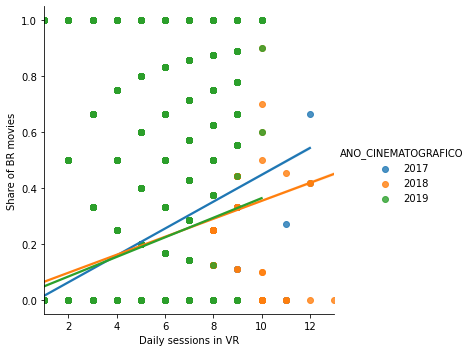

In [9]:
sns.lmplot(x='Daily sessions in VR', y='Share of BR movies', data=corr, hue='ANO_CINEMATOGRAFICO')

#### 2017-2018

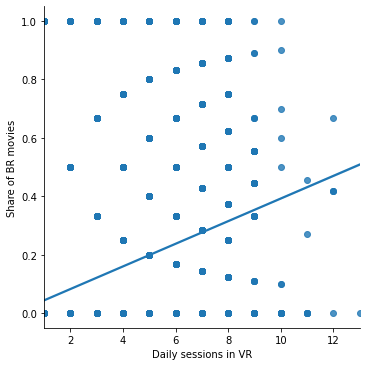

In [42]:
sns.lmplot(x='Daily sessions in VR', y='Share of BR movies', data=corr_17)

#### 2019

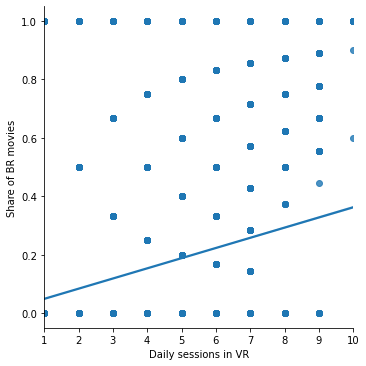

In [41]:
sns.lmplot(x='Daily sessions in VR', y='Share of BR movies', data = corr_19)

#### Quick regressions

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
# rename columns
ren = {'Share of BR movies':'Share_of_BR_movies', 'Daily sessions in VR':'Daily_sessions_in_VR'}

corr.rename(columns=ren, inplace=True)
# corr_17.rename(columns=ren, inplace=True)
# corr_19.rename(columns=ren, inplace=True)

In [11]:
del scb_trab

In [12]:
corr

,REGISTRO_SALA,DATA,REGISTRO_COMPLEXO,REGISTRO_GRUPO,Share_of_BR_movies,Daily_sessions_in_VR,ANO_CINEMATOGRAFICO
0,5000056,2017-01-05,2387,6000037.0,0.0,4,2017
1,5000056,2017-01-06,2387,6000037.0,0.0,4,2017
2,5000056,2017-01-07,2387,6000037.0,0.0,4,2017
3,5000056,2017-01-08,2387,6000037.0,0.0,4,2017
4,5000056,2017-01-09,2387,6000037.0,0.0,4,2017
...,...,...,...,...,...,...,...
3391218,5006528,2019-12-27,45032,6000008.0,0.0,3,2019
3391219,5006528,2019-12-28,45032,6000008.0,0.0,3,2019
3391220,5006528,2019-12-29,45032,6000008.0,0.0,3,2019
3391221,5006528,2019-12-30,45032,6000008.0,0.0,3,2019


In [13]:
reg = smf.ols('Daily_sessions_in_VR ~ C(REGISTRO_GRUPO) + C(ANO_CINEMATOGRAFICO)*Share_of_BR_movies',
             data=corr).fit()

MemoryError: Unable to allocate 6.19 GiB for an array with shape (245, 3391223) and data type float64

### Pizzaplots: sessions, public, and income as a fraction of nationality

Text(0.5, 1.0, 'Renda de filme ESTRANGEIRO')

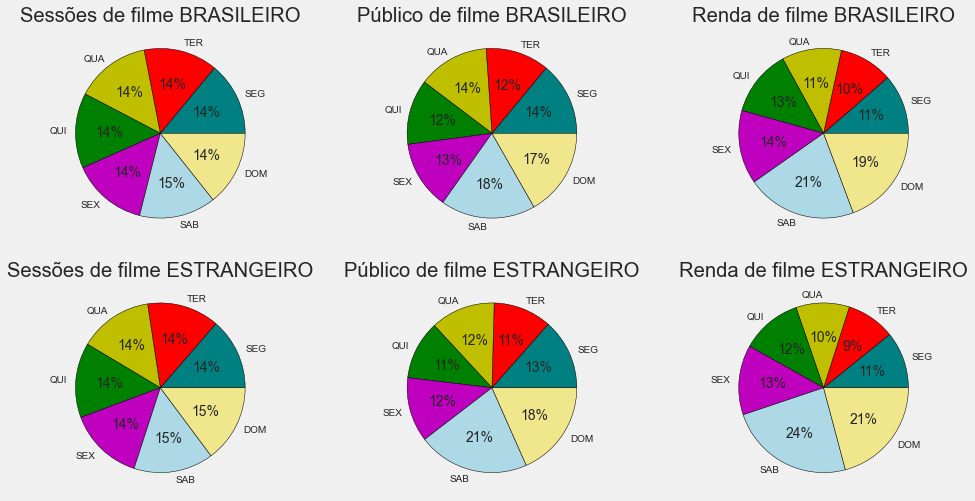

In [7]:
# gráficos pizza com sessões, público e renda por dia da semana #

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(2,3,figsize=(15,8), sharex=True)

colors = ['teal','r','y','g','m','lightblue','khaki']

lab=['SEG', 'TER', 'QUA', 'QUI', 'SEX' , 'SAB' , 'DOM']
wdgps = {'edgecolor':'black'}

ax[0,0].pie(sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").DATA_SESSAO, labels=lab, autopct='%1.0f%%',
           wedgeprops=wdgps, colors=colors)
ax[1,0].pie(sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").DATA_SESSAO, labels=lab, autopct='%1.0f%%',
           wedgeprops=wdgps, colors=colors)
ax[0,0].set_title("Sessões de filme BRASILEIRO")
ax[1,0].set_title("Sessões de filme ESTRANGEIRO")

ax[0,1].pie(sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").PUBLICO, labels=lab, autopct='%1.0f%%',
           wedgeprops=wdgps, colors=colors)
ax[1,1].pie(sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").PUBLICO, labels=lab, autopct='%1.0f%%',
           wedgeprops=wdgps, colors=colors)
ax[0,1].set_title("Público de filme BRASILEIRO")
ax[1,1].set_title("Público de filme ESTRANGEIRO")

ax[0,2].pie(sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").RENDA_ATUALIZADA_JAN20, labels=lab, autopct='%1.0f%%',
           wedgeprops=wdgps, colors=colors)
ax[1,2].pie(sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").RENDA_ATUALIZADA_JAN20, labels=lab, autopct='%1.0f%%',
           wedgeprops=wdgps, colors=colors)
ax[0,2].set_title("Renda de filme BRASILEIRO")
ax[1,2].set_title("Renda de filme ESTRANGEIRO")

#### Pearson Chi-Squared tests to check whether differences are significant

In [35]:
# testes qui-quadrado de Pearson para testar as hipóteses:
# 1) Se a distribuição de sessões, público e renda de filmes brasileiros e estrangeiros são iguais ao longo da semana
# 2) Se a distribuição de sessões, público e renda de filmes de filmes brasileiros e estrangeiros são distintas

from scipy.stats import chi2_contingency

ses_br = sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").DATA_SESSAO
pub_br = sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").PUBLICO
ren_br = sessoes_dia_semana.query("NACIONALIDADE == 'BRASILEIRA'").RENDA_ATUALIZADA_JAN20

ses_est = sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").DATA_SESSAO
pub_est = sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").PUBLICO
ren_est = sessoes_dia_semana.query("NACIONALIDADE == 'ESTRANGEIRA'").RENDA_ATUALIZADA_JAN20

# criando uma distribuição uniforme para os dias da semana

null = [1/7 for x in range(7)]

# transformando isso nos valores esperados dadas as observações em cada caso

null_ses_br = np.multiply(null, ses_br.sum())
null_pub_br = np.multiply(null, pub_br.sum())
null_ren_br = np.multiply(null, ren_br.sum())

null_ses_est = np.multiply(null, ses_est.sum())
null_pub_est = np.multiply(null, pub_est.sum())
null_ren_est = np.multiply(null, ren_est.sum())

# criando as matrizes com dados em que temos os valores observados na primeira linha e esperados na segunda

ses_br_dat = np.stack((ses_br, null_ses_br), axis=0)
pub_br_dat = np.stack((pub_br, null_pub_br), axis=0)
ren_br_dat = np.stack((ren_br, null_ren_br), axis=0)

ses_est_dat = np.stack((ses_est, null_ses_est), axis=0)
pub_est_dat = np.stack((pub_est, null_pub_est), axis=0)
ren_est_dat = np.stack((ren_est, null_ren_est), axis=0)

# criando as matrizes com valores de brasileiros e estrangeiros para comparar se vem da mesma distribuição

ses_comp_dat = np.stack((ses_br, ses_est), axis=0)
pub_comp_dat = np.stack((pub_br, pub_est), axis=0)
ren_comp_dat = np.stack((ren_br, ren_est), axis=0)

# calculando as estatísticas e criando um DataFrame

_, p, dof, _ = chi2_contingency(ses_br_dat)
_, p2, dof2, _ = chi2_contingency(ses_est_dat)

_, p3, dof3, _ = chi2_contingency(pub_br_dat)
_, p4, dof4, _ = chi2_contingency(pub_est_dat)

_, p5, dof5, _ = chi2_contingency(ren_br_dat)
_, p6, dof6, _ = chi2_contingency(ren_est_dat)

_, p7, dof7, _ = chi2_contingency(ses_comp_dat)
_, p8, dof8, _ = chi2_contingency(pub_comp_dat)
_, p9, dof9, _ = chi2_contingency(ren_comp_dat)

df = pd.DataFrame({'p-value':[p,p2,p3,p4,p5,p6,p7,p8,p9], 'DoF':[dof,dof2,dof3,dof4,dof5,dof6,dof7,dof8,dof9]}, 
                  index=['Sessões Brasileiras','Sessões Estrangeiras','Público Brasileiras','Público Estrangeiras',
                         'Renda Brasileiras','Renda Estrangeiras','Sessões Bras vs. Est','Pub Bras vs. Est',
                         'Renda Bras. vs. Est'])

df

,p-value,DoF
Sessões Brasileiras,3.274872e-36,6
Sessões Estrangeiras,0.000000e+00,6
Público Brasileiras,0.000000e+00,6
Público Estrangeiras,0.000000e+00,6
Renda Brasileiras,0.000000e+00,6
Renda Estrangeiras,0.000000e+00,6
Sessões Bras vs. Est,1.836879e-219,6
Pub Bras vs. Est,0.000000e+00,6
Renda Bras. vs. Est,0.000000e+00,6


## Sesssions by starting hour

In [38]:
# criando base para fazer gráfico de sessões por hora do dia

scb_trab.loc[:,'HORA_DA_SESSAO'] = scb_trab.loc[:,'HORA_SESSAO'].apply(lambda x: x.hour)

ag_hora = scb_trab.query("COMERCIAL == 'COMERCIAL'").groupby(['NACIONALIDADE', 'HORA_DA_SESSAO'], as_index=False).agg({
    'DATA_SESSAO':'count','RENDA_ATUALIZADA_JAN20':'sum', 'PUBLICO':'sum'
})

# rótulos dos horários de início das sessões

labels = []

for i in ag_hora.HORA_DA_SESSAO.unique():
    if i < 10:
        hora = '0'+str(i)+':00 to 0'+str(i)+':59'
    else:
        hora = str(i)+':00 to '+str(i)+':59'
    labels.append(hora)

# criando colunas de valores normalizados    

for i in range(ag_hora.shape[0]):
    nac = ag_hora.loc[i,'NACIONALIDADE']
    ses_nac = np.sum(ag_hora.query("NACIONALIDADE == @nac").DATA_SESSAO)
    pub_nac = np.sum(ag_hora.query("NACIONALIDADE == @nac").PUBLICO)
    rend_nac = np.sum(ag_hora.query("NACIONALIDADE == @nac").RENDA_ATUALIZADA_JAN20)
    ag_hora.loc[i,'SESSOES_NORM'] = ag_hora.loc[i,'DATA_SESSAO'] / ses_nac
    ag_hora.loc[i,'PUBLICO_NORM'] = ag_hora.loc[i,'PUBLICO'] / pub_nac
    ag_hora.loc[i,'RENDA_NORM'] = ag_hora.loc[i,'RENDA_ATUALIZADA_JAN20'] / rend_nac
    
# criando valores percentuais de brasileiros vs. estrangeiros dentro de cada hora
    
soma_hora = ag_hora.groupby(['HORA_DA_SESSAO']).sum()[['DATA_SESSAO', 'RENDA_ATUALIZADA_JAN20', 'PUBLICO']]

for i in range(ag_hora.shape[0]):
    hora = ag_hora.loc[i,'HORA_DA_SESSAO']
    for c in ['DATA_SESSAO', 'RENDA_ATUALIZADA_JAN20', 'PUBLICO']:
        nome = c+'_PROP'
        ag_hora.loc[i,nome] = ag_hora.loc[i,c] / soma_hora.loc[hora,c]    

### Sessions, income, and moviegoers per starting hour, normalized by nationality

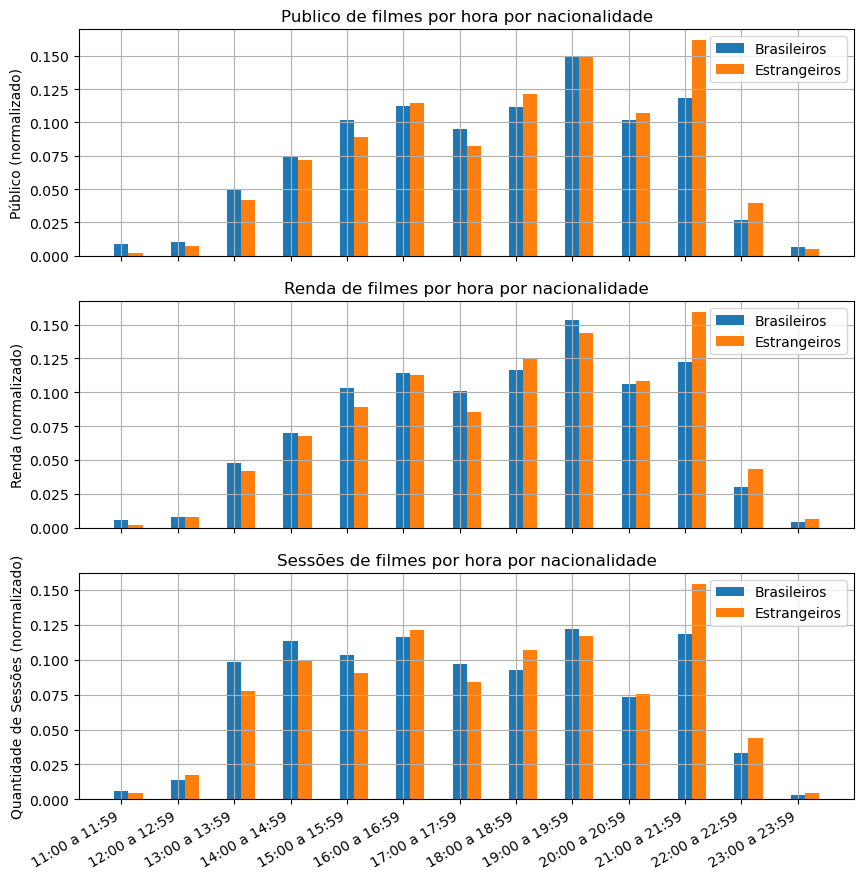

In [60]:
# criando o gráfico normalizado de renda, público e sessões por hora #

width = 0.25

x_ind = np.arange(13)
deg = 30

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=True)

ax3.bar(x_ind, ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].SESSOES_NORM, label='Brasileiros', width=width)

ax3.bar(x_ind + width, ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].SESSOES_NORM, label='Estrangeiros', width=width)

ax3.set_title("Sessões de filmes por hora por nacionalidade")
ax3.set_ylabel("Quantidade de Sessões (normalizado)")
ax3.legend()
ax3.grid(True)

ax1.bar(x_ind, ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].PUBLICO_NORM, label='Brasileiros', width=width)

ax1.bar(x_ind + width, ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].PUBLICO_NORM, label='Estrangeiros', width=width)

ax1.set_title("Publico de filmes por hora por nacionalidade")
ax1.set_ylabel("Público (normalizado)")
ax1.legend()
ax1.grid(True)

ax2.bar(x_ind, ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].RENDA_NORM, label='Brasileiros', width=width)

ax2.bar(x_ind + width, ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].RENDA_NORM, label='Estrangeiros', width=width)

ax2.set_title("Renda de filmes por hora por nacionalidade")
ax2.set_ylabel("Renda (normalizado)")
ax2.legend()
ax2.grid(True)

plt.xticks(x_ind, labels[11:],rotation=deg, ha='right')

plt.show()

### Stacked (foreign and Brazilian) barplot: sessions, income and moviegoers per starting hour

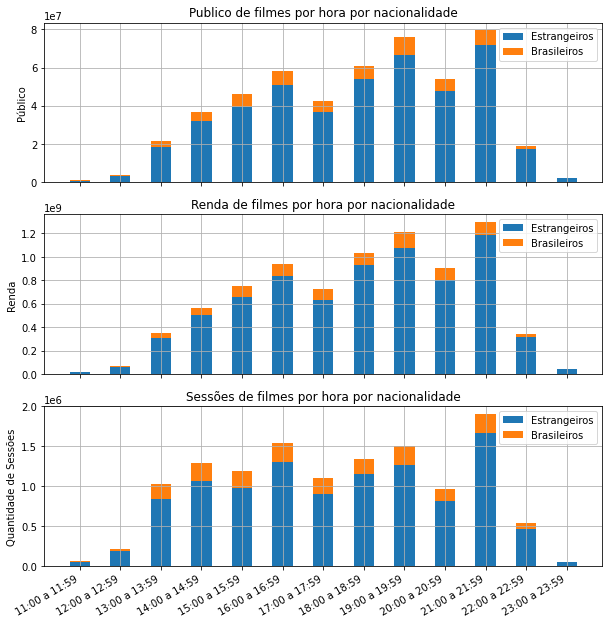

In [39]:
# gráfico de barras empilhadas de sessões, público e renda por hora e nacionalidade #

x_ind = np.arange(13)
deg = 30

width = 0.5

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=True)

sessao_bras = ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].DATA_SESSAO
sessao_est = ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].DATA_SESSAO

pub_bras = ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].PUBLICO
pub_est = ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].PUBLICO

renda_bras = ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].RENDA_ATUALIZADA_JAN20
renda_est = ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].RENDA_ATUALIZADA_JAN20

ax1.bar(x_ind, pub_est, label='Estrangeiros', width=width)
ax1.bar(x_ind, pub_bras, label='Brasileiros', width=width, bottom=pub_est)

ax1.set_title("Publico de filmes por hora por nacionalidade")
ax1.set_ylabel("Público")
ax1.legend()
ax1.grid(True)

ax2.bar(x_ind, renda_est, label='Estrangeiros', width=width)
ax2.bar(x_ind, renda_bras, label='Brasileiros', width=width, bottom=renda_est)

ax2.set_title("Renda de filmes por hora por nacionalidade")
ax2.set_ylabel("Renda")
ax2.legend()
ax2.grid(True)

ax3.bar(x_ind, sessao_est, label='Estrangeiros', width=width)
ax3.bar(x_ind, sessao_bras, label='Brasileiros', width=width, bottom=sessao_est)

ax3.set_title("Sessões de filmes por hora por nacionalidade")
ax3.set_ylabel("Quantidade de Sessões")
ax3.legend()
ax3.grid(True)

plt.xticks(x_ind, labels[11:],rotation=deg, ha='right')

plt.show()

### Normalized Stacked (foreign and Brazilian) barplot: sessions, income and moviegoers per starting hour

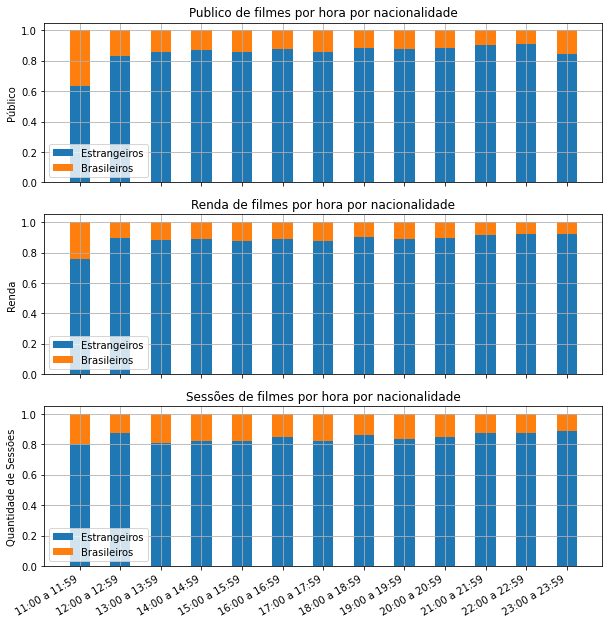

In [14]:
# gráfico de barras empilhadas de sessões, público e renda por hora e nacionalidade #

x_ind = np.arange(13)
deg = 30

width = 0.5

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=True)

sessao_bras = ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].DATA_SESSAO_PROP
sessao_est = ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].DATA_SESSAO_PROP

pub_bras = ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].PUBLICO_PROP
pub_est = ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].PUBLICO_PROP

renda_bras = ag_hora[(ag_hora.NACIONALIDADE == 'BRASILEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].RENDA_ATUALIZADA_JAN20_PROP
renda_est = ag_hora[(ag_hora.NACIONALIDADE == 'ESTRANGEIRA') & (ag_hora.HORA_DA_SESSAO >= 11)].RENDA_ATUALIZADA_JAN20_PROP

ax1.bar(x_ind, pub_est, label='Estrangeiros', width=width)
ax1.bar(x_ind, pub_bras, label='Brasileiros', width=width, bottom=pub_est)

ax1.set_title("Publico de filmes por hora por nacionalidade")
ax1.set_ylabel("Público")
ax1.legend()
ax1.grid(True)

ax2.bar(x_ind, renda_est, label='Estrangeiros', width=width)
ax2.bar(x_ind, renda_bras, label='Brasileiros', width=width, bottom=renda_est)

ax2.set_title("Renda de filmes por hora por nacionalidade")
ax2.set_ylabel("Renda")
ax2.legend()
ax2.grid(True)

ax3.bar(x_ind, sessao_est, label='Estrangeiros', width=width)
ax3.bar(x_ind, sessao_bras, label='Brasileiros', width=width, bottom=sessao_est)

ax3.set_title("Sessões de filmes por hora por nacionalidade")
ax3.set_ylabel("Quantidade de Sessões")
ax3.legend()
ax3.grid(True)

plt.xticks(x_ind, labels[11:],rotation=deg, ha='right')

plt.show()

In [41]:
# testes estatísticos para as sessões

ses_comp = np.stack((sessao_bras, sessao_est), axis=0)
pub_comp = np.stack((pub_bras, pub_est), axis=0)
ren_comp = np.stack((renda_bras, renda_est), axis=0)

_, p, dof, _ = chi2_contingency(ses_comp)
_, p2, dof2, _ = chi2_contingency(pub_comp)
_, p3, dof3, _ = chi2_contingency(ren_comp)

df = pd.DataFrame({'p-value':[p,p2,p3], 'DoF':[dof,dof2,dof3]}, 
                  index=['Sessões Bras vs. Est','Pub Bras vs. Est',
                         'Renda Bras. vs. Est'])

df

,p-value,DoF
Sessões Bras vs. Est,0.0,12
Pub Bras vs. Est,0.0,12
Renda Bras. vs. Est,0.0,12


## Avg Ticket Prices (PMIs) by nationality
*Calculated as the ratio between total income and total ticket sales*

In [ ]:
# PMI brasileiros vs. estrangeiros por ano #

plt.style.use('default')

PMIs = scb_trab.query("COMERCIAL == 'COMERCIAL'").groupby(['NACIONALIDADE', 'ANO_CINEMATOGRAFICO'], as_index=False).agg({
    'RENDA_ATUALIZADA_JAN20':'sum', 'PUBLICO':'sum'
})

PMIs.loc[:,'PMI'] = PMIs.loc[:,'RENDA_ATUALIZADA_JAN20'] / PMIs.loc[:,'PUBLICO']

### By year: 2017, 2018, 2019

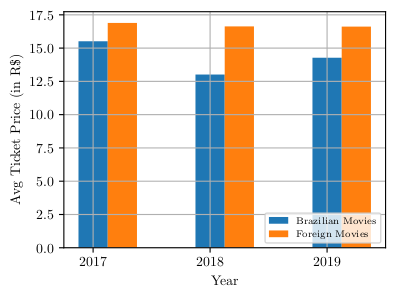

In [10]:
plt.figure(figsize=set_size(300))

x_index2 = np.arange(3)

width=0.25

plt.bar(x_index2, PMIs[PMIs.NACIONALIDADE == 'BRASILEIRA'].PMI, label='Brazilian Movies', width=width)

plt.bar(x_index2 + width, PMIs[PMIs.NACIONALIDADE == 'ESTRANGEIRA'].PMI, label='Foreign Movies', width=width)

plt.xticks(x_index2, [2017, 2018, 2019])

plt.legend(fontsize='x-small', loc='lower right')

plt.xlabel("Year")
plt.ylabel("Avg Ticket Price (in R\$)")
plt.grid(True)

plt.savefig('PMI.pgf', format='pgf')

In [23]:
# PMI brasileiros vs. estrangeiros por ano por dia da semana #

plt.style.use('default')

PMIs_dia = scb_trab.query("COMERCIAL == 'COMERCIAL'").groupby(['DIA_SEMANA', 'NACIONALIDADE'], 
        as_index=False).agg({'RENDA_ATUALIZADA_JAN20':'sum', 'PUBLICO':'sum'
})
PMIs_dia = PMIs_dia.reindex([6,7,12,13,2,3,4,5,8,9,10,11,0,1])

PMIs_dia.loc[:,'PMI'] = PMIs_dia.loc[:,'RENDA_ATUALIZADA_JAN20'] / PMIs_dia.loc[:,'PUBLICO']

### By weekday

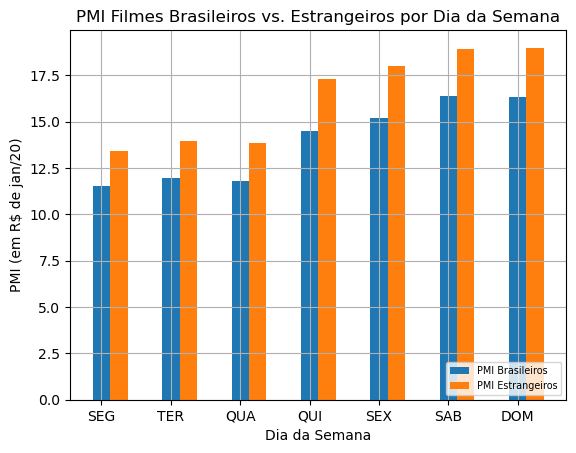

In [27]:
# gráfico

x_index2 = np.arange(7)

width=0.25

plt.bar(x_index2, PMIs_dia[PMIs_dia.NACIONALIDADE == 'BRASILEIRA'].PMI, label='PMI Brasileiros', width=width)
plt.bar(x_index2 + width, PMIs_dia[PMIs_dia.NACIONALIDADE == 'ESTRANGEIRA'].PMI, label='PMI Estrangeiros', width=width)

plt.xticks(x_index2, ['SEG', 'TER', 'QUA', 'QUI', 'SEX' , 'SAB' , 'DOM'])

plt.legend(fontsize='x-small', loc='lower right')

plt.title("PMI Filmes Brasileiros vs. Estrangeiros por Dia da Semana")
plt.xlabel("Week Day")
plt.ylabel("PMI (em R$ de jan/20)")
plt.grid(True)

In [ ]:
# PMI brasileiros vs. estrangeiros por ano por dia da semana, ano a ano #

plt.style.use('default')

PMIs_dia = scb_trab.query("COMERCIAL == 'COMERCIAL'").groupby(['ANO_CINEMATOGRAFICO', 'DIA_SEMANA', 'NACIONALIDADE'], 
        as_index=False).agg({'RENDA_ATUALIZADA_JAN20':'sum', 'PUBLICO':'sum'
})

lista = [6,7,12,13,2,3,4,5,8,9,10,11,0,1]
lista2 = list(map(lambda x: x+14, lista))
lista3 = list(map(lambda x: x+14, lista2))

lista.extend(lista2)
lista.extend(lista3)

PMIs_dia = PMIs_dia.reindex(lista)
PMIs_dia.loc[:,'PMI'] = PMIs_dia.loc[:,'RENDA_ATUALIZADA_JAN20'] / PMIs_dia.loc[:,'PUBLICO']

### By weekday/year

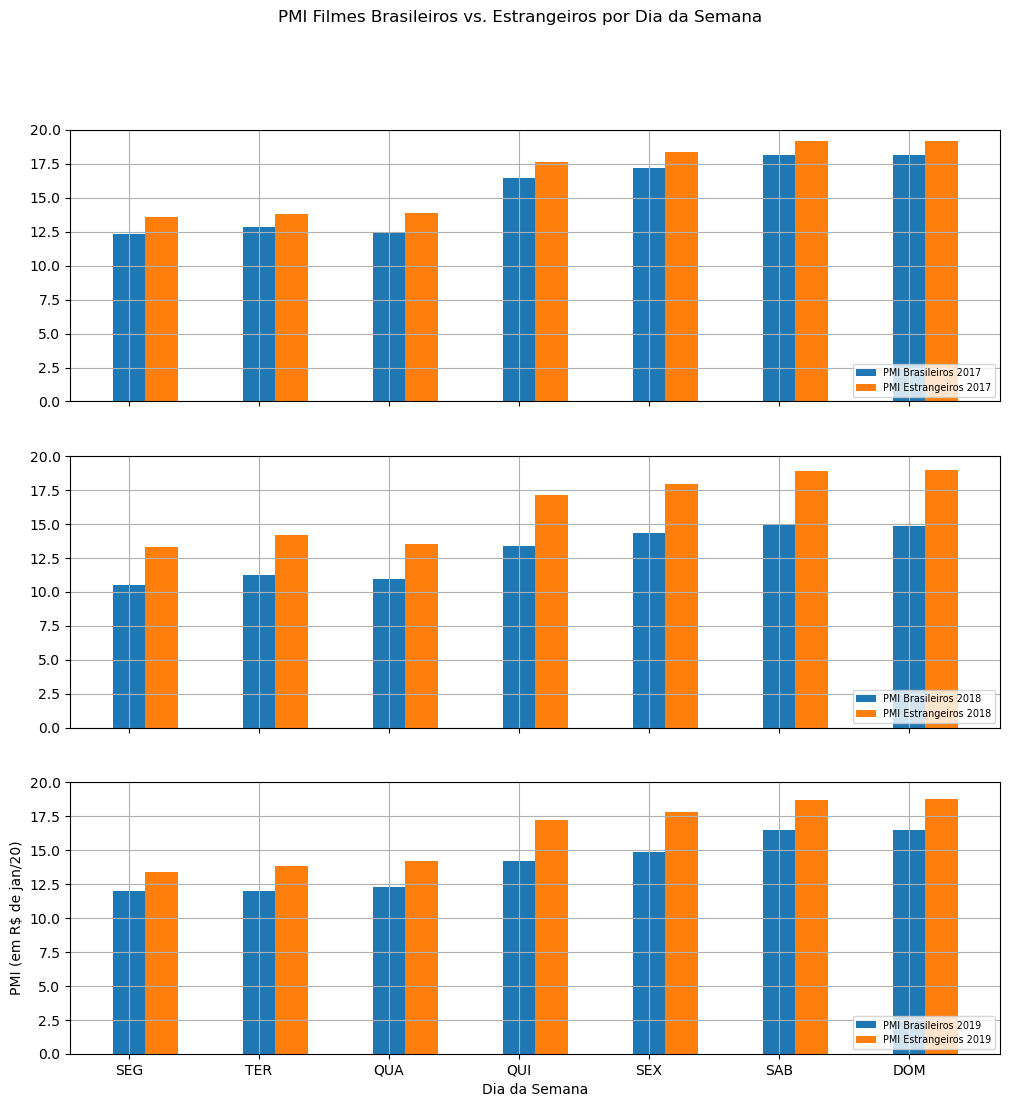

In [12]:
# plotando o gráfico

fig, (ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(12,12), sharex=True)

x_index2 = np.arange(7)

width=0.25

ax1.bar(x_index2, PMIs_dia[(PMIs_dia.NACIONALIDADE == 'BRASILEIRA') & (PMIs_dia.ANO_CINEMATOGRAFICO == 2017)].PMI,
        label='PMI Brasileiros 2017', width=width)
ax1.bar(x_index2 + width, PMIs_dia[(PMIs_dia.NACIONALIDADE == 'ESTRANGEIRA') & (PMIs_dia.ANO_CINEMATOGRAFICO == 2017)].PMI,
        label='PMI Estrangeiros 2017', width=width)
ax1.grid(True)
ax1.legend(fontsize='x-small', loc='lower right')
ax1.set_ylim(0,20)
ax1.set_title('Ano de 2017')

ax2.bar(x_index2, PMIs_dia[(PMIs_dia.NACIONALIDADE == 'BRASILEIRA') & (PMIs_dia.ANO_CINEMATOGRAFICO == 2018)].PMI,
        label='PMI Brasileiros 2018', width=width)
ax2.bar(x_index2 + width, PMIs_dia[(PMIs_dia.NACIONALIDADE == 'ESTRANGEIRA') & (PMIs_dia.ANO_CINEMATOGRAFICO == 2018)].PMI,
        label='PMI Estrangeiros 2018', width=width)
ax2.grid(True)
ax2.legend(fontsize='x-small', loc='lower right')
ax2.set_ylim(0,20)
ax2.set_title('Ano de 2018')

ax3.bar(x_index2, PMIs_dia[(PMIs_dia.NACIONALIDADE == 'BRASILEIRA') & (PMIs_dia.ANO_CINEMATOGRAFICO == 2019)].PMI,
        label='PMI Brasileiros 2019', width=width)
ax3.bar(x_index2 + width, PMIs_dia[(PMIs_dia.NACIONALIDADE == 'ESTRANGEIRA') & (PMIs_dia.ANO_CINEMATOGRAFICO == 2019)].PMI,
        label='PMI Estrangeiros 2019', width=width)
ax3.set_ylim(0,20)
ax3.set_title('Ano de 2019')


plt.xticks(x_index2, ['SEG', 'TER', 'QUA', 'QUI', 'SEX' , 'SAB' , 'DOM'])

plt.legend(fontsize='x-small', loc='lower right')

fig.suptitle("PMI Filmes Brasileiros vs. Estrangeiros por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("PMI (em R$ de jan/20)")
plt.grid(True)

## Seasonality

In [8]:
scb_trab.columns

Index(['ANO_CINEMATOGRAFICO', 'SEMANA_CINEMATOGRAFICA', 'PRIMEIRO_DIA_SEMANA',
       'ULTIMO_DIA_SEMANA', 'DATA_SESSAO', 'DIA_SEMANA',
       'QUALIFICADOR_DIA_SEMANA', 'HORA_SESSAO', 'DATA_HORA_SESSAO',
       'TIPO_SESSAO', 'REGISTRO_SALA', 'REGISTRO_COMPLEXO', 'CPB_ROE',
       'TITULO', 'NACIONALIDADE', 'PUBLICO', 'RENDA', 'QT_ASSENTOS_SALA',
       'CEP_COMPLEXO', 'MUN_COMPLEXO', 'UF_COMPLEXO', 'TOT_SALAS_FUNC',
       'COMERCIAL', 'REG_EMPRESA', 'AGE', 'GRUPO_EXIBIDOR', 'OCUPAÇÃO_SALAS',
       'ANO_MES', 'FATOR', 'RENDA_ATUALIZADA_JAN20', 'REGISTRO_GRUPO',
       'ASSENTOS_INFERIDO', 'OCUPAÇÃO_SALA_INFERIDA', 'SALAS_GRUPO_INFERIDO',
       'SALAS_COMPLEXO_INFERIDO', 'ASSENTOS_COMPLEXO_INFERIDO',
       'ASSENTOS_GRUPO_INFERIDO', 'HORA_ajustada', 'DIAS_FUNCIONAMENTO',
       'DATA', 'DIAS_FUNCIONAMENTO_GRUPO', 'OBRIGAÇÃO_TOTAL_POR_SALA_GRUPO',
       'OBRIGAÇÃO_FINAL_POR_SALA_GRUPO', 'CUMPRIMENTO_PROPORCIONAL_GRUPO',
       'CUMPRIMENTO_PROP_TRUNCADO_GRUPO', 'CUMPRIMENTO_TRIWEIG

In [9]:
gby = ['ANO_CINEMATOGRAFICO','SEMANA_CINEMATOGRAFICA']

season_dict = {'DATA_SESSAO':'count', 'PUBLICO':'sum', 'RENDA_ATUALIZADA_JAN20':'sum'}

weekly = scb_trab.groupby(gby, as_index=False).agg(season_dict)

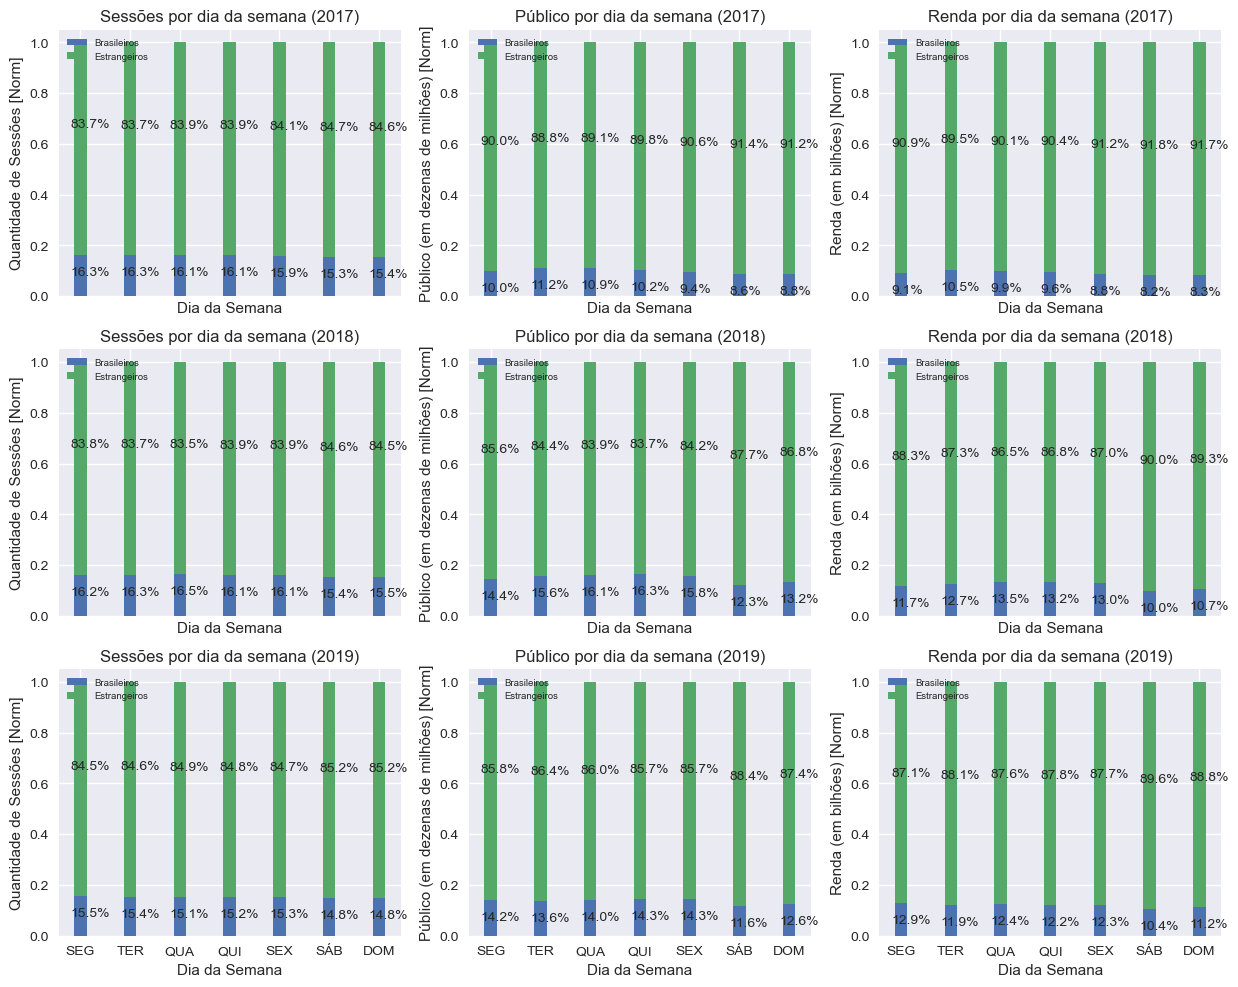

In [69]:
# código para geração dos barplots #

plt.style.use('seaborn')

x_index = np.arange(7)

width=0.25

rows = 3 # if rows = 1, have to remove subscript from ax object, ax[col] and not ax[row][col]
cols = 3

fig, ax = plt.subplots(rows,cols,figsize=(15,12), dpi=100, sharex=True)

data = [sessoes_dia_semana_17, sessoes_dia_semana_18, sessoes_dia_semana_19]

attrib = ['DATA_SESSAO_NORMALIZADO', 'PUBLICO_NORMALIZADO', 'RENDA_ATUALIZADA_JAN20_NORMALIZADO']

idx = 0

tit_labels = ['Sessões', 'Público', 'Renda']

y_labels = ["Quantidade de Sessões","Público (em dezenas de milhões)","Renda (em bilhões)"]

norm_labels = [y+r' [Norm]' for y in y_labels]


for row in range(rows):
    for col in range(cols):
        bottom = data[row].query("NACIONALIDADE == 'BRASILEIRA'").reset_index()[attrib[col]]
        top = data[row].query("NACIONALIDADE == 'ESTRANGEIRA'").reset_index()[attrib[col]]
        ax[row][col].bar(x_index, bottom, label='Brasileiros', width=width)
        ax[row][col].bar(x_index, top, label='Estrangeiros', width=width, bottom=bottom)
        
        # percentage text comment
        for i in range(7):
            ax[row][col].text(i-0.2,(bottom[i] - 0.08), f'{np.round(bottom[i]*100,1)}%')
            ax[row][col].text(i-0.2,(bottom[i] + 0.5), f'{np.round(top[i]*100,1)}%')
        
        # settings
        ax[row][col].legend(loc='upper left', fontsize='x-small')
        ax[row][col].set_title(f"{tit_labels[col]} por dia da semana ({2017+row})")
        ax[row][col].set_xlabel("Dia da Semana")
        ax[row][col].set_ylabel(norm_labels[col])
        ax[row][col].grid(True)
        

plt.xticks(x_index, [d[:3] for d in sessoes_dia_semana.DIA_SEMANA.unique()])
plt.show()

## Gráficos de ocupação das salas

In [28]:
# criando dataframe só com as sessões para as quais a ocupação pode ser calculada (isto é, para os casos em que a info
# está disponível no SAD)

sessoes_ocup=scb_trab[(scb_trab.COMERCIAL == 'COMERCIAL') & (scb_trab.OCUPAÇÃO_SALAS.notna())]

# removendo todas as salas que aparecem com mais de 105% de ocupação em algum momento, dados que sua informação no SAD deve 
# estar defeituosa

salas = sessoes_ocup.query("OCUPAÇÃO_SALAS >= 1.05").REGISTRO_SALA.unique()
dic_salas = {k:1 for k in salas}

# mapeando e removendo as salas que não tiveram o 1 #

sessoes_ocup.loc[:,'REMOVER'] = sessoes_ocup.loc[:,'REGISTRO_SALA'].map(dic_salas)

sessoes_ocup = sessoes_ocup[sessoes_ocup.REMOVER.isna()]

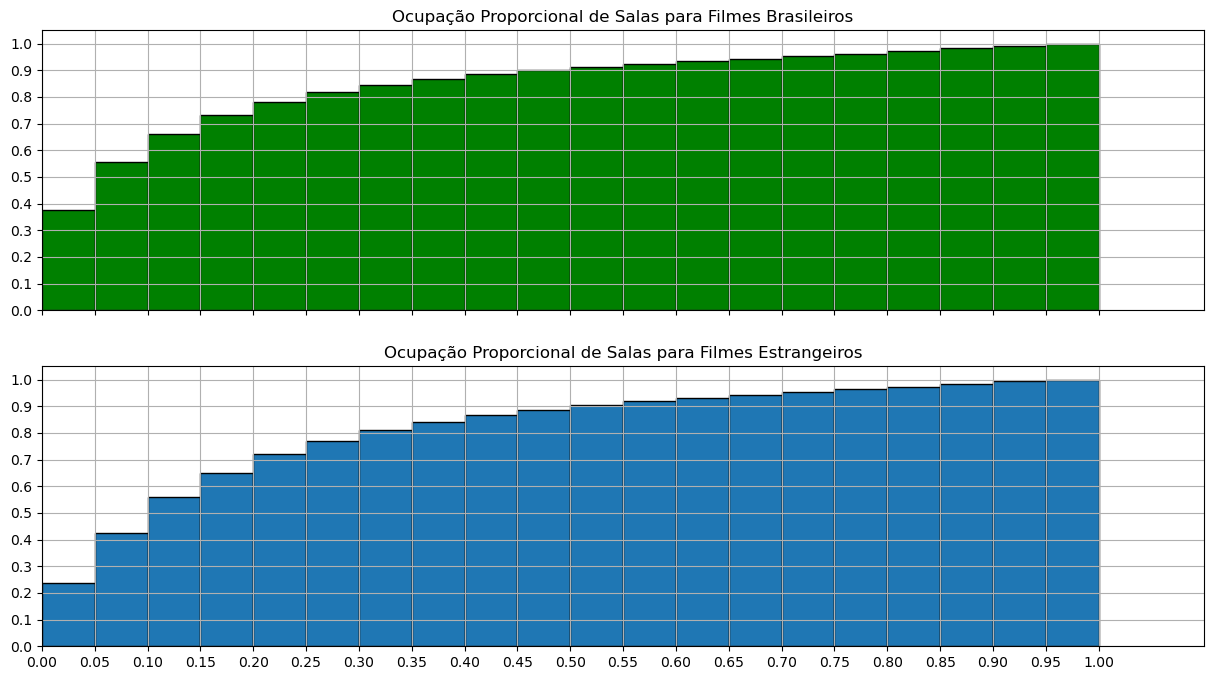

In [31]:
# fazendo o histograma comparando ocupação de brasileiros e estrangeiros #

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,8), sharex=True)

bins = [x/20 for x in range(21)]

ax1.hist(sessoes_ocup.query("NACIONALIDADE == 'BRASILEIRA'").OCUPAÇÃO_SALAS, bins=bins,
         ec='black', density=True, cumulative=True, color='green')
ax1.set_title("Ocupação Proporcional de Salas para Filmes Brasileiros")
ax1.set_xlim(0,1.1)
ax1.set_yticks([x/10 for x in range(11)])
ax1.grid(True)

ax2.hist(sessoes_ocup.query("NACIONALIDADE == 'ESTRANGEIRA'").OCUPAÇÃO_SALAS, bins=bins,
         ec='black', density=True, cumulative=True)
ax2.set_title("Ocupação Proporcional de Salas para Filmes Estrangeiros")
ax2.set_xlim(0,1.1)
ax2.grid(True)
ax2.set_yticks([x/10 for x in range(11)])

plt.xticks([x/20 for x in range(21)])

plt.show()

In [53]:
from scipy.stats import cumfreq

# fazendo histograma plotado

oc_br = scipy.stats.cumfreq(sessoes_ocup.query("NACIONALIDADE == 'BRASILEIRA'").OCUPAÇÃO_SALAS, numbins=20,
                           defaultreallimits=(0,1))
oc_est = scipy.stats.cumfreq(sessoes_ocup.query("NACIONALIDADE == 'ESTRANGEIRA'").OCUPAÇÃO_SALAS, numbins=20,
                            defaultreallimits=(0,1))

# pegando só os valores do histograma e normalizando para 1
br = [0]
est = [0]

for i in oc_br[0]:
    br.append(i/oc_br[0][-1])
    
for i in oc_est[0]:
    est.append(i/oc_est[0][-1])

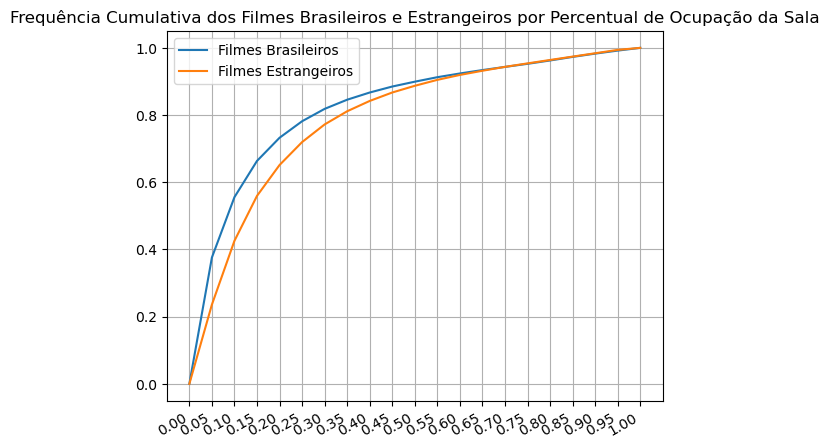

In [57]:
ind = [x/20 for x in range(21)]

plt.plot(ind,br, label='Filmes Brasileiros')
plt.plot(ind,est, label='Filmes Estrangeiros')
plt.grid(True)
plt.legend()
plt.title("Frequência Cumulativa dos Filmes Brasileiros e Estrangeiros por Percentual de Ocupação da Sala")
plt.xticks([x/20 for x in range(21)],rotation=45,ha='right')
plt.show()